In [1]:
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import shapely.geometry as sg
import pandas as pd
import scipy.spatial as ss
import matplotlib as mpl

import os
import json
import numpy as np
import squidpy as sq
import cv2

import sklearn
import statannotations
from cellpose import utils as cu



import spatial_rgc.utils.model_constants as constants
%matplotlib auto
#FOR NIKHIL: CHANGE THIS

DATA_DIR= os.path.join(constants.BASE_DIR,"data")
MOSAIC_DATA_DIR = os.path.join(DATA_DIR,"mosaic_data")
FIGURE_DIR = os.path.join(constants.BASE_DIR,"figures","Figure_4")
REVIEWER_DIR = os.path.join(constants.BASE_DIR,"..","reviewer_figs")

#REGION_DIR = os.path.join("..","..","regions") #Ignore for now; only for VDRI
WIDE_CONTEXT = {'font.size':8,'figure.dpi':300}

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

NULL_COLOR, OBSERVED_COLOR = 'lightgrey', 'royalblue'
JOINT_ADATA = "merged_control_cluster_final_mapped.h5ad"
MOSAIC_SIM_DIR = os.path.join(DATA_DIR,"mosaic_hole_analysis")
CONTEXT = {'figure.dpi':200, 'font.sans-serif':'Arial','font.size':8}
CLASS_CMAP= plt.get_cmap('tab20')
CLASS_PALETTE={'Amacrine':CLASS_CMAP(0),'Non-neuronal':CLASS_CMAP(6), 'Low quality neuronal':CLASS_CMAP(14),'RGC':CLASS_CMAP(2)}

Using matplotlib backend: <object object at 0x7fb7610990f0>


# Construct analyses

In [2]:
def update_coords(adata,col_x='aligned_center_y',col_y='aligned_center_y'):
    alignment = {
        3:{'center':(2900,9476),'reflect':False,'rotate':135},
        4:{'center':(4250,11200),'reflect':True,'rotate':124},
        5:{'center':(2350,9850),'reflect':True,'rotate':-69},
        7:{'center':(7550,9250),'reflect':True,'rotate':-30},
        16:{'center':(11200,1900),'reflect':True,'rotate':-60},#16 and 17 seem reasonable but may need adjustment
        17:{'center':(12910,3750),'reflect':False,'rotate':130},
    }

    #Note: updates aligned_center_x in place! (run this more than once and you'll get a bug...)

    def rotate_clockwise(x,y,degrees):
        theta = np.deg2rad(degrees)
        rot_mat=np.array([[np.cos(theta),np.sin(theta)],[-np.sin(theta),np.cos(theta)]])
        rotated = rot_mat @ np.array([x,y])
        return np.array([rotated[0],rotated[1]]).T

    adata.obs['dorsal']=True
    adata.obs['nasal']=True
    adata.obs['D/V']='Dorsal'
    adata.obs['N/T']='Nasal'
    for run in alignment:
        ar= alignment[run]
        adata_r = adata[adata.obs['run']==run]

        #recenter
        adata_r.obs[col_x]=adata_r.obs[col_x]-ar['center'][0]
        adata_r.obs[col_y]=adata_r.obs[col_y]-ar['center'][1]
        #reflect
        if ar['reflect']:
            adata_r.obs[col_x]=-adata_r.obs[col_x]
        #rotate
        output=rotate_clockwise(adata_r.obs[col_x].values,adata_r.obs[col_y].values,ar['rotate'])
        adata_r.obs[[col_x,col_y]]=rotate_clockwise(adata_r.obs[col_x].values,adata_r.obs[col_y].values,ar['rotate'])
        adata_r.obs['dorsal'] = adata_r.obs[col_y]>0
        adata_r.obs['D/V']=adata_r.obs['dorsal'].apply(lambda x: 'Dorsal' if x else 'Ventral')
        adata_r.obs['nasal']=adata_r.obs[col_x]<0    
        adata_r.obs['N/T']=adata_r.obs['nasal'].apply(lambda x: 'Nasal' if x else 'Temporal')
        adata.obs.update(adata_r.obs)
        print(adata.obs.columns)
    



def create_C16_subclass_and_SAC(adata,old_col='final_assignment',new_col='subtyped_assignments',class_col='class'):
    adata.obs['Calb1'] = pd.Series(adata[:,'Calb1'].X.toarray()[:,0],index=adata.obs.index)
    try:
        adata.obs[new_col] = pd.Categorical(adata.obs[old_col])
        adata.obs[new_col]= adata.obs[old_col].cat.add_categories(['C16_D','C16_V','SAC'])
    except Exception as e:
        raise AssertionError(e)
    adata.obs.loc[(adata.obs['Calb1'] > 1.75) & (adata.obs[new_col]=='C16') ,new_col] = 'C16_D'
    adata.obs.loc[(adata.obs['Calb1'] <= 1.75) & (adata.obs[new_col]=='C16'),new_col] = 'C16_V'
    adata.obs.loc[(adata.obs['retina_class'] == 'GabaAC') &(adata.obs['joint_leiden'] == '0') ,new_col] = 'SAC'
    adata.obs.loc[(adata.obs['retina_class'] == 'GabaAC') &(adata.obs['joint_leiden'] == '0') ,class_col] = 'Amacrine'
    adata.obs[new_col] = adata.obs[new_col].cat.remove_categories(['C16'])

def make_square(xl,yl,d):
    return [[xl,yl],[xl+d,yl],[xl+d,yl+d],[xl,yl+d]]

In [3]:
good_ROI = {
    3:{
        0:[make_square(95,-1052,920)], #for zoom in: make_square(444,-643,400)
        1:[make_square(-1350,-850,600)], 
    },
    5:{
        0:[make_square(350, 60 ,780)], 
        1:[make_square(-1500, -600 ,780),  
           make_square(-600, -1520 ,780), 
           make_square(300, -500 ,1300), 
           ]
    },
    7:{
        0:[make_square(-1521,-94,700)],
        1:[make_square(935,0,1000)],
    },
    16:{
        3:[make_square(-500, -1500 ,1000)]  # good, LARGE w/ holes
    },
}

add_ROI = {
    3:{
        0:[make_square(95,-1052,920)], 
        1:[make_square(-1350,-850,600),make_square(-700,382,600)], #new
    },
    5:{
        0:[make_square(350, 60 ,780)], 
        1:[make_square(-1500, -600 ,780),  
           make_square(-600, -1520 ,780), 
           make_square(300, -500 ,1300), 
           ]
    },
    7:{
        0:[make_square(-1521,-94,700),make_square(277,-1493,600),make_square(714,225,700)],#2 new
        1:[make_square(935,0,1000)],
    },
    16:{
        3:[make_square(-500, -1500 ,1000)]  
    },
    17:{
        4:[make_square(-1248, 120 , 800),make_square(722,-364,700)]  
    }
}

whole_section_ROI = {
    3:{
        0:[make_square(-1170,-1700,3000)],
        1:[make_square(-1500,-2200,3500)]
    },
    5:{
        1:[make_square(-1600,-1650,3500)],
    },
    7:{
        0:[make_square(-1850,-1850,4000)],
        1:[make_square(-2000,-2000,4000)]
    },
    16:{
        3:[make_square(-1500,-1900,4000)]
    },
    17:{
        4:[make_square(-2164,-1670,4000)]
    }
}



bounding_roi = {
    '140g_rn3_rg0':{
        'ex0':{'xl':1500,'xu':5500,'yl':3000,'yu':7000},
    },
    '140g_rn3_rg1':{
        'ex1':{'xl':4500,'xu':7500,'yl':500,'yu':3500},
    },
    '140g_rn5_rg0':{
        'ex0':{'xl':500,'xu':3500,'yl':500,'yu':3500}
    },
    '140g_rn5_rg1':{
        'ex0':{'xl':2500,'xu':7500,'yl':4500,'yu':7500},
        'ex1':{'xl':5000,'xu':8000,'yl':2000,'yu':5000},
        'ex2':{'xl':500,'xu':5500,'yl':500,'yu':3500}
    },
    '140g_rn7_rg0':{
        #'ex1':{'xl':1500,'xu':3500,'yl':4000,'yu':6000},
        'ex0':{'xl':4500,'xu':8000,'yl':4500,'yu':8000},
    },
    '140g_rn7_rg1':{
        'ex1':{'xl':500,'xu':4500,'yl':1500,'yu':5500},
    },
    '140g_rn16_rg3':{
        'ex1':{'xl':3500,'xu':7000,'yl':500,'yu':5000},
    }
}


In [20]:


adata=sc.read_h5ad(os.path.join(DATA_DIR,"control_130_6",JOINT_ADATA))
adata.obs[['realigned_center_x','realigned_center_y']] = adata.obs[['aligned_center_x','aligned_center_y']]
update_coords(adata,col_x='realigned_center_x',col_y='realigned_center_y')
# with open(os.path.join(REGION_DIR,"ROIS.json"), 'r') as f:
#     run_region = json.load(f)

suffix=""
adata.obs['region'] = adata.obs['region'].astype(int)
create_C16_subclass_and_SAC(adata,old_col=f'final_assignment{suffix}',new_col=f'final_assignment{suffix}',class_col=f'class{suffix}')

#Remove segmentation artifacts
import networkx as nx
adata.obs['dup'] = False
ctypes = ['SAC','Amacrine'] + [f"C{i}" for i in range(1,15)] + ["C16_V", "C16_D"] + [f"C{i}" for i in range(17,46)]
cutoff_map = {'C41':10,'C42':10,'C43':10,'C45':10,'SAC':10,'Amacrine':4}
G = nx.Graph()
for run in adata.obs['run'].unique():
    for region in adata.obs[adata.obs['run']==run]['region'].unique():
        adata_r = adata[(adata.obs['run']==run) & (adata.obs['region']==region)]
        for ctype in ctypes:
            ctype_xy = adata_r.obs[adata_r.obs[f'final_assignment{suffix}']==ctype][['aligned_center_x','aligned_center_y']]
            if len(ctype_xy)  <= 1:
                continue

            nbrs_model = sklearn.neighbors.NearestNeighbors(n_neighbors=2,algorithm='ball_tree').fit(ctype_xy)
            distances, indices=  nbrs_model.kneighbors(ctype_xy)

            import networkx as nx
            if ctype not in cutoff_map:
                cutoff = 4
            else:
                cutoff = cutoff_map[ctype]
            nearest_dist = []
            for i,j in enumerate(indices[:,1]):
                nearest_dist.append(distances[i,1])
                if distances[i,1] < cutoff:
                    G.add_edge(ctype_xy.iloc[i].name,ctype_xy.iloc[j].name,distance=distances[i,1])

for comp in nx.connected_components(G):
    ordered_comp  = sorted(list(comp))
    for i,idx in enumerate(ordered_comp):
        if i> 0:
            adata.obs.loc[ordered_comp[i],'dup'] = True

/var/folders/b3/jkbfjl310vdb0w4vhhz87pdr0000gn/T/ipykernel_3010/1595588504.py:28: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_r.obs[col_x]=adata_r.obs[col_x]-ar['center'][0]


Index(['Size', 'center_x', 'center_y', 'max_areas', 'aligned_center_x',
       'aligned_center_y', 'counts', 'class', 'final_assignment', 'run',
       'joint_leiden', 'retina_class', 'new_x', 'new_y', 'in_boundary',
       'dorsal', 'nasal', 'D/V', 'N/T', 'final_x', 'final_y', 'Anti-Rat',
       'CD31+', 'class_v2', 'final_assignment_v2', 'class_v3',
       'final_assignment_v3', 'region', 'realigned_center_x',
       'realigned_center_y'],
      dtype='object')


/var/folders/b3/jkbfjl310vdb0w4vhhz87pdr0000gn/T/ipykernel_3010/1595588504.py:28: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_r.obs[col_x]=adata_r.obs[col_x]-ar['center'][0]


Index(['Size', 'center_x', 'center_y', 'max_areas', 'aligned_center_x',
       'aligned_center_y', 'counts', 'class', 'final_assignment', 'run',
       'joint_leiden', 'retina_class', 'new_x', 'new_y', 'in_boundary',
       'dorsal', 'nasal', 'D/V', 'N/T', 'final_x', 'final_y', 'Anti-Rat',
       'CD31+', 'class_v2', 'final_assignment_v2', 'class_v3',
       'final_assignment_v3', 'region', 'realigned_center_x',
       'realigned_center_y'],
      dtype='object')


/var/folders/b3/jkbfjl310vdb0w4vhhz87pdr0000gn/T/ipykernel_3010/1595588504.py:28: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_r.obs[col_x]=adata_r.obs[col_x]-ar['center'][0]


Index(['Size', 'center_x', 'center_y', 'max_areas', 'aligned_center_x',
       'aligned_center_y', 'counts', 'class', 'final_assignment', 'run',
       'joint_leiden', 'retina_class', 'new_x', 'new_y', 'in_boundary',
       'dorsal', 'nasal', 'D/V', 'N/T', 'final_x', 'final_y', 'Anti-Rat',
       'CD31+', 'class_v2', 'final_assignment_v2', 'class_v3',
       'final_assignment_v3', 'region', 'realigned_center_x',
       'realigned_center_y'],
      dtype='object')


/var/folders/b3/jkbfjl310vdb0w4vhhz87pdr0000gn/T/ipykernel_3010/1595588504.py:28: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_r.obs[col_x]=adata_r.obs[col_x]-ar['center'][0]


Index(['Size', 'center_x', 'center_y', 'max_areas', 'aligned_center_x',
       'aligned_center_y', 'counts', 'class', 'final_assignment', 'run',
       'joint_leiden', 'retina_class', 'new_x', 'new_y', 'in_boundary',
       'dorsal', 'nasal', 'D/V', 'N/T', 'final_x', 'final_y', 'Anti-Rat',
       'CD31+', 'class_v2', 'final_assignment_v2', 'class_v3',
       'final_assignment_v3', 'region', 'realigned_center_x',
       'realigned_center_y'],
      dtype='object')


/var/folders/b3/jkbfjl310vdb0w4vhhz87pdr0000gn/T/ipykernel_3010/1595588504.py:28: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_r.obs[col_x]=adata_r.obs[col_x]-ar['center'][0]


Index(['Size', 'center_x', 'center_y', 'max_areas', 'aligned_center_x',
       'aligned_center_y', 'counts', 'class', 'final_assignment', 'run',
       'joint_leiden', 'retina_class', 'new_x', 'new_y', 'in_boundary',
       'dorsal', 'nasal', 'D/V', 'N/T', 'final_x', 'final_y', 'Anti-Rat',
       'CD31+', 'class_v2', 'final_assignment_v2', 'class_v3',
       'final_assignment_v3', 'region', 'realigned_center_x',
       'realigned_center_y'],
      dtype='object')


/var/folders/b3/jkbfjl310vdb0w4vhhz87pdr0000gn/T/ipykernel_3010/1595588504.py:28: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_r.obs[col_x]=adata_r.obs[col_x]-ar['center'][0]


Index(['Size', 'center_x', 'center_y', 'max_areas', 'aligned_center_x',
       'aligned_center_y', 'counts', 'class', 'final_assignment', 'run',
       'joint_leiden', 'retina_class', 'new_x', 'new_y', 'in_boundary',
       'dorsal', 'nasal', 'D/V', 'N/T', 'final_x', 'final_y', 'Anti-Rat',
       'CD31+', 'class_v2', 'final_assignment_v2', 'class_v3',
       'final_assignment_v3', 'region', 'realigned_center_x',
       'realigned_center_y'],
      dtype='object')


In [23]:
#DELETE
from matplotlib.patches import Rectangle
import re
%matplotlib inline
all_f = os.listdir(os.path.join(DATA_DIR,"projected_masks"))
valid_ids = set()
valid_one_z_ids = set()

for f in all_f:
    match = re.search(r"projected_masks_([0-9]+)_([0-9]+)_z7_ex([0-9]+).npy",f)
    if match is None:
        print(f, "does not match the ROI file format; skipping")
        continue
    rn,rg,ex = str(match.group(1)),match.group(2),match.group(3)
    masks = np.load(os.path.join(DATA_DIR,"projected_masks",f))

    ids = np.unique(masks).flatten().tolist()
    ids = set( [str(x) + "_rg{}_rn{}".format(rg,rn) for x in ids] )

    with open(os.path.join(DATA_DIR,"info_data","info_{}_{}_z7_ex{}.json".format(rn,rg,ex)),'rb') as f:
        info = json.load(f)
        one_z_ids = set( [str(int(x)) + "_rg{}_rn{}".format(rg,rn) for x in info['7']] )



    valid_ids = valid_ids.union(ids)
    valid_one_z_ids = valid_one_z_ids.union(one_z_ids)


adata.obs['Keep'] = adata.obs.index.isin(valid_ids)
adata.obs['Keep_1z'] = adata.obs.index.isin(valid_one_z_ids)

projected_masks_4_1_z7_WHOLE.npy does not match the ROI file format; skipping
projected_masks_4_0_z7_WHOLE.npy does not match the ROI file format; skipping
projected_masks_4_2_z7_WHOLE.npy does not match the ROI file format; skipping
projected_masks_4_3_z7_WHOLE.npy does not match the ROI file format; skipping


/var/folders/b3/jkbfjl310vdb0w4vhhz87pdr0000gn/T/ipykernel_2971/1434432983.py:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(props_df,x='class',y='Proportion of cells kept',capsize=0.1,err_kws={'linewidth':1,'color':'black'},errorbar=('sd',1),palette=CLASS_PALETTE)


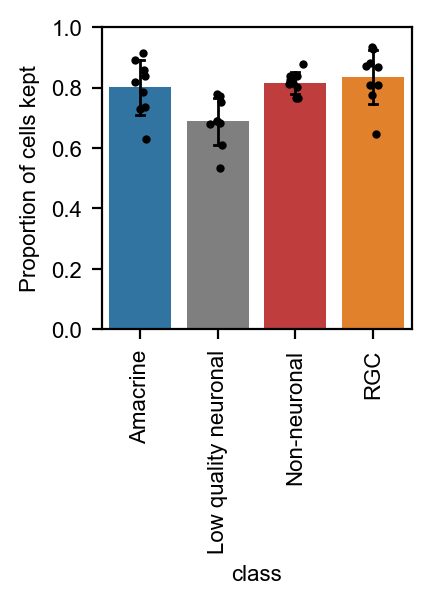

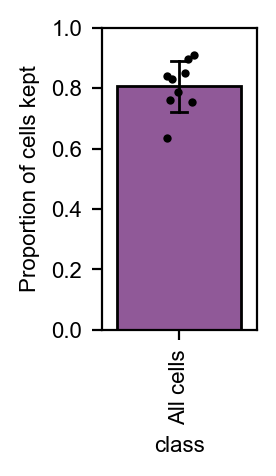

In [116]:
#DELETE
from matplotlib.patches import Rectangle
%matplotlib inline
ROI_dict = good_ROI

filt_col = 'Keep'
cmap_s1 = plt.get_cmap('Set1')

col_to_color = {'Keep_1z':cmap_s1(0),'Keep':cmap_s1(3)}
kept_props = []
total_props = []
for run in ROI_dict:
    square_rgs = ROI_dict[run]
    
    for rg in square_rgs:
        adata_r = adata[(adata.obs['run']==run)  & (adata.obs['region']==rg)]
        rois = square_rgs[rg]
        
        for i,roi in enumerate(rois):
            xl,yl = roi[0]
            d = roi[1][0] - xl
            with plt.rc_context({'figure.dpi':200}):


                df = adata_r.obs
                df = df[df['realigned_center_x'].between(xl,xl+d) & df['realigned_center_y'].between(yl,yl+d)]
                #plt.figure()

                counts = df.groupby(['class',filt_col]).size().reset_index(name='Count')
                total_props.append(df[filt_col].value_counts(normalize=True)[True])


                props = (counts.groupby(['class',filt_col])['Count'].sum()/counts.groupby(['class'])['Count'].sum()).reset_index(name='Proportion of cells kept')
                props = props[props[filt_col]==True]
                props['sample'] = "140g_rn{}_rg{}_ex{}".format(run,region,i)
                kept_props.append(props)
  

figure_dir=os.path.join(REVIEWER_DIR,"mosaic")

with plt.rc_context({'figure.dpi':200,'font.sans-serif':'Arial','font.family':'sans-serif','font.size':8,'figure.figsize':(2,2)}):
    props_df = pd.concat(kept_props)
    sns.barplot(props_df,x='class',y='Proportion of cells kept',capsize=0.1,err_kws={'linewidth':1,'color':'black'},errorbar=('sd',1),palette=CLASS_PALETTE)
    sns.stripplot(props_df,x='class',y='Proportion of cells kept',color='black',s=3)
    plt.xticks(rotation=90)
    plt.ylim(0,1)
    plt.savefig(os.path.join(figure_dir,"{}_cells_fraction.png".format(filt_col)),bbox_inches='tight')
    plt.show()

with plt.rc_context({'figure.dpi':200,'font.sans-serif':'Arial','font.family':'sans-serif','font.size':8,'figure.figsize':(1,2)}):
    total_props_df = pd.DataFrame({'Proportion of cells kept': total_props,'class':'All cells'})
    sns.barplot(total_props_df,x='class',y='Proportion of cells kept',capsize=0.1,err_kws={'linewidth':1,'color':'black'},color=col_to_color[filt_col],edgecolor='black',errorbar=('sd',1))
    sns.stripplot(total_props_df,x='class',y='Proportion of cells kept',color='black',s=3)
    plt.xticks(rotation=90)
    plt.ylim(0,1)
    plt.savefig(os.path.join(REVIEWER_DIR,"mosaic","{}_ALL_cells_fraction.pdf".format(filt_col)),bbox_inches='tight')
    plt.show()
    

## Find NNRI/VDRI

In [6]:
def calc_NNRI2(coords):
    coords = np.array(coords)
    nbrs_model = sklearn.neighbors.NearestNeighbors(n_neighbors=2,algorithm='ball_tree').fit(coords)
    distances, indices=  nbrs_model.kneighbors(coords)
    return distances[:,1]#don't return self neighbor

def calc_VDRI2(vor,bound_poly=None,exclusion_polygons=None):
    areas = []

    for rg in vor.regions:
        if len(rg) == 0:
            continue
        valid = True
        n, i = len(rg), 0
        indices = []
        while i < n and valid:
            if rg[i] == -1:
                valid = False
            else:
                indices.append(rg[i])
            i+=1
        
        
        if valid:
            area = 0
            vor_poly = sg.Polygon(vor.vertices[indices])
            area += vor_poly.area
            for exc in exclusion_polygons:
                area -= vor_poly.intersection(exc).area
            
            if bound_poly is not None:
                area -= vor_poly.difference(bound_poly).area

            areas.append(area)
        
    
    return areas

def run_NNRI(adata,ctype,run,region,ex,polys,x='realigned_center_x',y='realigned_center_y',group_key='class',group='RGC',key='final_assignment',random_key='randomized_assignment',n_iters=100,min_distance=None,roi_name=None,figure_dir=os.path.join("figures","random_regular")):
    df = adata.obs
    sample_poly = sg.Polygon(polys[run][region][ex])
    xl,yl,xu,yu = np.round(list(sample_poly.bounds))
    filt = ( (df[group_key]== group) ) & df[x].between(xl,xu) & df[y].between(yl,yu) & (df['run']==run) & (df['region']==region) 
    df_rgc = df[filt].copy()
    df_rgc['bound_distance'] = np.minimum( np.minimum(df_rgc[x] - xl, xu - df_rgc[x]), np.minimum(df_rgc[y] - yl, yu - df_rgc[y]))
    if min_distance:
        df_rgc['filt_dist'] = pd.Series(calc_NNRI2(df_rgc[[x,y]].values),df_rgc.index)
        df_rgc = df_rgc[df_rgc['filt_dist'] > 8]

    if len(df_rgc[df_rgc[key]==ctype]) <= 1:
        print("SKIPPING ROI {}_{}_{} FOR {} due to lack of cells".format(run,region,ex,ctype))
        return {'flag':True}
    
    null_total = []


    for _ in range(n_iters):
        df_rgc[random_key] = pd.Series(df_rgc[key].sample(frac=1).values,df_rgc[key].index)
        df_c = df_rgc[df_rgc[random_key]==ctype].copy()
        df_c['min_distance'] = pd.Series(calc_NNRI2(df_c[[x,y]].values),df_c.index)
        filt_min_distances =  df_c[df_c['min_distance'] < df_rgc.loc[list(df_c.index)]['bound_distance']]['min_distance'].values
        null_total.extend(list(filt_min_distances))
    
    #obserrved
    df_o = df_rgc[df_rgc[key]==ctype].copy()
    df_o['min_distance'] = pd.Series(calc_NNRI2(df_o[[x,y]].values),df_o.index)
    obs_min_distances = df_o[(df_o['min_distance'] < df_rgc.loc[list(df_o.index)]['bound_distance']) & (df_o['min_distance'] > 7)]['min_distance']
    #plt.hist(null_total,color='grey',alpha=0.5,density=True)
    #plt.hist(obs_min_distances,color='blue',alpha=0.5,density=True)
    title = "Celltype, {} Run, {}, region, {}, ex, {}  n_filt, {}".format(ctype,run,region,ex,len(df_o))
    null_NNRI, obs_NNRI = np.mean(null_total)/np.std(null_total), np.mean(obs_min_distances)/np.std(obs_min_distances), 
    print("Ctype: {}, Null NNRI: {}, Observed NNRI: {}".format(ctype,null_NNRI,obs_NNRI))
    # plt.figure()
    # plt.title(title)
    # sns.kdeplot(data=null_total)
    # sns.kdeplot(data=obs_min_distances)
    # plt.xlim(0,100)
    #plt.savefig(os.path.join(figure_dir,"NN_dist_{}.png".format(title)))
    # plt.show()
    # plt.figure()
    # sns.scatterplot(df_o,x=x,y=y)
    # plt.title("Run: {}, region: {}, ex: {}  n_orig: {} n_filt: {}".format(run,region,ex,len(obs_min_distances),len(df_o)))

    #sns.scatterplot(df_rgc[df_rgc['final_assignment']!=ctype],x=x,y=y,color='red',s=5)
    #sns.scatterplot(df_c,x=x,y=y,color='black',s=10)

    if roi_name is None:
        roi_name = 'rn{}_rg{}_ex{}'.format(run,region,ex)
    n,m = len(null_total),len(obs_min_distances)
    df = pd.DataFrame(data={
        'distances':np.concatenate((null_total,obs_min_distances)),
        'roi': [roi_name]*(n+m),
        'Category': ["Null"]*n + ["Observed"]*m,
        'Type': [ctype] * (n+m)
        },
        index= ["{}_{}".format(roi_name,i) for i in range(n+m)]
    )
    nnri_data = pd.DataFrame({'NNRI':[null_NNRI,obs_NNRI],'Category':['Null','Observed'],'Type':[ctype]},index = ["{}_{}_random".format(roi_name,ctype),"{}_{}_observed".format(roi_name,ctype)])
    return {'distance_data':df, 'nnri_data':nnri_data}




def run_VDRI(adata,ctype,run,region,ex,polys,x='realigned_center_x',y='realigned_center_y',group='RGC',group_key='class',key='final_assignment',random_key='randomized_assignment',n_iters=100,min_distance=None,roi_name=None,figure_dir=os.path.join("figures","random_regular"),exclusion_polygons=None,bound_poly=None):
    df = adata.obs
    sample_poly = sg.Polygon(polys[run][region][ex])
    xl,yl,xu,yu = np.round(list(sample_poly.bounds))
    filt = (df[group_key]== group) & df[x].between(xl,xu) & df[y].between(yl,yu) & (df['run']==run) & (df['region']==region) 
    df_rgc = df[filt].copy()
    if min_distance:
        df_rgc['filt_dist'] = pd.Series(calc_VDRI2(df_rgc[[x,y]].values),df_rgc.index,bound_poly=bound_poly,exclusion_polygons=exclusion_polygons)
        df_rgc = df_rgc[df_rgc['filt_dist'] > 8]
    
    if len(df_rgc[df_rgc[key]==ctype]) <= 3:
        print("SKIPPING ROI {}_{}_{} FOR {} due to lack of cells".format(run,region,ex,ctype))
        return {'flag':True}

    null_total = []

    for i in range(n_iters):
        df_rgc[random_key] = pd.Series(df_rgc[key].sample(frac=1).values,df_rgc[key].index)
        df_c = df_rgc[df_rgc[random_key]==ctype].copy()
        vor = ss.Voronoi(df_c[[x,y]])
        areas = calc_VDRI2(vor,bound_poly=bound_poly,exclusion_polygons=exclusion_polygons)
        null_total.extend(areas)
    
    #observed
    df_o = df_rgc[df_rgc[key]==ctype].copy()

    obs_min_areas = calc_VDRI2(ss.Voronoi(df_o[[x,y]]),bound_poly=bound_poly,exclusion_polygons=exclusion_polygons)
    null_VDRI = np.mean(null_total)/np.std(null_total)
    obs_VDRI = np.mean(obs_min_areas)/np.std(obs_min_areas)
    print("Ctype: {}, Null VDRI: {}, Observed VDRI: {}".format(ctype,null_VDRI,obs_VDRI))

    print("")

    if roi_name is None:
        roi_name = 'rn{}_rg{}_ex{}'.format(run,region,ex)
    n,m = len(null_total),len(obs_min_areas)
    df = pd.DataFrame(data={
        'areas':np.concatenate((null_total,obs_min_areas)),
        'roi': [roi_name]*(n+m),
        'Category': ["Null"]*n + ["Observed"]*m,
        'Type': [ctype] * (n+m)
        },
        index= ["{}_{}".format(roi_name,i) for i in range(n+m)]
    )
    vdri_data = pd.DataFrame({'VDRI':[null_VDRI,obs_VDRI],'Category':['Null','Observed'],'Type':[ctype]},index = ["{}_{}_random".format(roi_name,ctype),"{}_{}_observed".format(roi_name,ctype)])
    return {'area_data':df, 'vdri_data':vdri_data}








In [7]:
import random
from collections import OrderedDict
import itertools

def calc_NNRI2(coords):
    coords = np.array(coords)
    nbrs_model = sklearn.neighbors.NearestNeighbors(n_neighbors=2,algorithm='ball_tree').fit(coords)
    distances, indices=  nbrs_model.kneighbors(coords)
    return distances[:,1]#don't return self neighbor

def calc_VDRI2(vor,bound_poly=None,exclusion_polygons=None):
    areas = []

    for rg in vor.regions:
        if len(rg) == 0:
            continue
        valid = True
        n, i = len(rg), 0
        indices = []
        while i < n and valid:
            if rg[i] == -1:
                valid = False
            else:
                indices.append(rg[i])
            i+=1
        
        
        if valid:
            area = 0
            vor_poly = sg.Polygon(vor.vertices[indices])
            area += vor_poly.area
            for exc in exclusion_polygons:
                area -= vor_poly.intersection(exc).area
            
            if bound_poly is not None:
                area -= vor_poly.difference(bound_poly).area

            areas.append(area)
        
    
    return areas

def run_NNRI2(adata,ctype,run,region,ex,polys,x='realigned_center_x',y='realigned_center_y',group_key='class',group='RGC',key='final_assignment',random_key='randomized_assignment',n_iters=100,min_distance=None,roi_name=None,include_boundary_cells=True,figure_dir=os.path.join("figures","random_regular")):
    from collections import OrderedDict
    df = adata.obs
    sample_poly = sg.Polygon(polys[run][region][ex])
    xl,yl,xu,yu = np.round(list(sample_poly.bounds))
    filt = ( (df[group_key]== group) ) & df[x].between(xl,xu) & df[y].between(yl,yu) & (df['run']==run) & (df['region']==region) 
    df_rgc = df[filt].copy()
    df_rgc['bound_distance'] = np.minimum( np.minimum(df_rgc[x] - xl, xu - df_rgc[x]), np.minimum(df_rgc[y] - yl, yu - df_rgc[y]))
    # if min_distance:
    #     df_rgc['filt_dist'] = pd.Series(calc_NNRI2(df_rgc[[x,y]].values),df_rgc.index)
    #     df_rgc = df_rgc[df_rgc['filt_dist'] > 8]

    if len(df_rgc[df_rgc[key]==ctype]) <= 1:
        print("SKIPPING ROI {}_{}_{} FOR {} due to lack of cells".format(run,region,ex,ctype))
        return {'flag':True}
    
    null_total = []
    sim_n = []


    for i in range(n_iters):
        df_rgc[random_key] = pd.Series(df_rgc[key].sample(frac=1).values,df_rgc[key].index)
        df_c = df_rgc[df_rgc[random_key]==ctype].copy()
        df_c['min_distance'] = pd.Series(calc_NNRI2(df_c[[x,y]].values),df_c.index)
        if include_boundary_cells:
            filt_min_distances = df_c['min_distance'].values
        else:
            filt_min_distances =  df_c[df_c['min_distance'] < df_rgc.loc[list(df_c.index)]['bound_distance']]['min_distance'].values
            
        null_total.extend(list(filt_min_distances))
        sim_n.extend([i]*len(filt_min_distances))
    
    #obserrved
    df_o = df_rgc[df_rgc[key]==ctype].copy()
    df_o['min_distance'] = pd.Series(calc_NNRI2(df_o[[x,y]].values),df_o.index)
    if include_boundary_cells:
        obs_min_distances = df_o['min_distance']

    else:
        obs_min_distances = df_o[(df_o['min_distance'] < df_rgc.loc[list(df_o.index)]['bound_distance'])]['min_distance'] # (df_o['min_distance'] > 7)
        
    #plt.hist(null_total,color='grey',alpha=0.5,density=True)
    #plt.hist(obs_min_distances,color='blue',alpha=0.5,density=True)
    title = "Celltype, {} Run, {}, region, {}, ex, {}  n_filt, {}".format(ctype,run,region,ex,len(df_o))
    null_NNRI, obs_NNRI = np.mean(null_total)/np.std(null_total), np.mean(obs_min_distances)/np.std(obs_min_distances), 
    print("Ctype: {}, Mean Null NNRI: {}, Observed NNRI: {}".format(ctype,null_NNRI,obs_NNRI))
   

    if roi_name is None:
        roi_name = 'rn{}_rg{}_ex{}'.format(run,region,ex)
    n,m = len(null_total),len(obs_min_distances)
    df = pd.DataFrame(data={
        'distances':np.concatenate((null_total,obs_min_distances)),
        'roi': [roi_name]*(n+m),
        'Category': ["Null"]*n + ["Observed"]*m,
        'Sim_number': sim_n + [0]*m,
        'Type': [ctype] * (n+m)
        },
        index= ["{}_{}".format(roi_name,i) for i in range(n+m)]
    )
    nnri_data = pd.DataFrame({'NNRI':[null_NNRI,obs_NNRI],'Category':['Mean Null','Observed'],'Type':[ctype]},index = ["{}_{}_random".format(roi_name,ctype),"{}_{}_observed".format(roi_name,ctype)])
    return {'distance_data':df, 'nnri_data':nnri_data}




def run_VDRI2(adata,ctype,run,region,ex,polys,x='realigned_center_x',y='realigned_center_y',group='RGC',group_key='class',key='final_assignment',random_key='randomized_assignment',n_iters=100,min_distance=None,roi_name=None,figure_dir=os.path.join("figures","random_regular"),exclusion_polygons=None,bound_poly=None):
    df = adata.obs
    sample_poly = sg.Polygon(polys[run][region][ex])
    xl,yl,xu,yu = np.round(list(sample_poly.bounds))
    filt = (df[group_key]== group) & df[x].between(xl,xu) & df[y].between(yl,yu) & (df['run']==run) & (df['region']==region) 
    df_rgc = df[filt].copy()
    if min_distance:
        df_rgc['filt_dist'] = pd.Series(calc_VDRI2(df_rgc[[x,y]].values),df_rgc.index,bound_poly=bound_poly,exclusion_polygons=exclusion_polygons)
        df_rgc = df_rgc[df_rgc['filt_dist'] > 8]
    
    print(len(df_rgc[df_rgc[key]==ctype]))
    
    if len(df_rgc[df_rgc[key]==ctype]) < 20:
        print("SKIPPING ROI {}_{}_{} FOR {} due to lack of cells".format(run,region,ex,ctype))
        return {'flag':True}

    null_total = []
    sim_n = []

    for i in range(n_iters):
        df_rgc[random_key] = pd.Series(df_rgc[key].sample(frac=1).values,df_rgc[key].index)
        df_c = df_rgc[df_rgc[random_key]==ctype].copy()
        vor = ss.Voronoi(df_c[[x,y]])
        areas = calc_VDRI2(vor,bound_poly=bound_poly,exclusion_polygons=exclusion_polygons)
        null_total.extend(areas)
        sim_n.extend([i]*len(areas))
    
    #observed
    df_o = df_rgc[df_rgc[key]==ctype].copy()

    obs_min_areas = calc_VDRI2(ss.Voronoi(df_o[[x,y]]),bound_poly=bound_poly,exclusion_polygons=exclusion_polygons)
    null_VDRI = np.mean(null_total)/np.std(null_total)
    obs_VDRI = np.mean(obs_min_areas)/np.std(obs_min_areas)
    print("Ctype: {}, Mean Null VDRI: {}, Observed VDRI: {}".format(ctype,null_VDRI,obs_VDRI))

    print("")

    if roi_name is None:
        roi_name = 'rn{}_rg{}_ex{}'.format(run,region,ex)
    n,m = len(null_total),len(obs_min_areas)
    df = pd.DataFrame(data={
        'areas':np.concatenate((null_total,obs_min_areas)),
        'roi': [roi_name]*(n+m),
        'Category': ["Null"]*n + ["Observed"]*m,
        'Sim_number': sim_n + [0]*m,
        'Type': [ctype] * (n+m)
        },
        index= ["{}_{}".format(roi_name,i) for i in range(n+m)]
    )
    vdri_data = pd.DataFrame({'VDRI':[null_VDRI,obs_VDRI],'Category':['Mean Null','Observed'],'Type':[ctype]},index = ["{}_{}_random".format(roi_name,ctype),"{}_{}_observed".format(roi_name,ctype)])
    return {'area_data':df, 'vdri_data':vdri_data}








In [8]:
good_ROI = {
    3:{
        0:[make_square(95,-1052,920)], #for zoom in: make_square(444,-643,400)
        1:[make_square(-1350,-850,600)], 
    },
    5:{
        0:[make_square(350, 60 ,780)], 
        1:[make_square(-1500, -600 ,780),  
           make_square(-600, -1520 ,780), 
           make_square(300, -500 ,1300), 
           ]
    },
    7:{
        0:[make_square(-1521,-94,700)],
        1:[make_square(935,0,1000)],
    },
    16:{
        3:[make_square(-500, -1500 ,1000)]  # good, LARGE w/ holes
    },
}


In [166]:
import tqdm
def reshuffle(bins):
    output = []
    for bin_g in bins:
        if len(bin_g) > 0:
            #print(bin_g)
            output.extend(random.sample(bin_g,len(bin_g)))

    return output
        

def run_NNRI3(adata,ctype,run,region,ex,polys,r_col,radii_bins,x='realigned_center_x',y='realigned_center_y',group_key='class',group='RGC',key='final_assignment',random_key='randomized_assignment',n_iters=100,min_distance=None,roi_name=None,include_boundary_cells=True,figure_dir=os.path.join("figures","random_regular")):
    df = adata.obs
    sample_poly = sg.Polygon(polys[run][region][ex])
    xl,yl,xu,yu = np.round(list(sample_poly.bounds))
    filt = ( (df[group_key]== group) ) & df[x].between(xl,xu) & df[y].between(yl,yu) & (df['run']==run) & (df['region']==region) 
    df_rgc = df[filt].copy()
    df_rgc['bound_distance'] = np.minimum( np.minimum(df_rgc[x] - xl, xu - df_rgc[x]), np.minimum(df_rgc[y] - yl, yu - df_rgc[y]))
    # if min_distance:
    #     df_rgc['filt_dist'] = pd.Series(calc_NNRI2(df_rgc[[x,y]].values),df_rgc.index)
    #     df_rgc = df_rgc[df_rgc['filt_dist'] > 8]

    arr = np.digitize(df_rgc[r_col].values,bins=radii_bins,right=False)
    ctypes_rad_binned = []
    # plt.hist(df_rgc[r_col],bins=radii_bins)
    # plt.show()
    #setup
    for i in range(len(radii_bins)+1):
        indices = np.where(arr==i)[0].tolist()
        ctypes_rad_binned.append(df_rgc.iloc[indices][key].values.tolist())
    #print(ctypes_rad_binned)

    if len(df_rgc[df_rgc[key]==ctype]) <= 1:
        print("SKIPPING ROI {}_{}_{} FOR {} due to lack of cells".format(run,region,ex,ctype))
        return {'flag':True}
    
    null_total = []
    sim_n = []


    for i in tqdm.tqdm(range(n_iters)):
        #df_rgc[random_key] = pd.Series(df_rgc[key].sample(frac=1).values,df_rgc[key].index)
        
        df_rgc[random_key] = pd.Series(reshuffle(ctypes_rad_binned),df_rgc[key].index)
        df_c = df_rgc[df_rgc[random_key]==ctype].copy()
        df_c['min_distance'] = pd.Series(calc_NNRI2(df_c[[x,y]].values),df_c.index)
        if include_boundary_cells:
            filt_min_distances = df_c['min_distance'].values
        else:
            filt_min_distances =  df_c[df_c['min_distance'] < df_rgc.loc[list(df_c.index)]['bound_distance']]['min_distance'].values
            
        null_total.extend(list(filt_min_distances))
        sim_n.extend([i]*len(filt_min_distances))
    
    #obserrved
    df_o = df_rgc[df_rgc[key]==ctype].copy()
    df_o['min_distance'] = pd.Series(calc_NNRI2(df_o[[x,y]].values),df_o.index)
    if include_boundary_cells:
        obs_min_distances = df_o['min_distance']

    else:
        obs_min_distances = df_o[(df_o['min_distance'] < df_rgc.loc[list(df_o.index)]['bound_distance'])]['min_distance'] # (df_o['min_distance'] > 7)
        
    #plt.hist(null_total,color='grey',alpha=0.5,density=True)
    #plt.hist(obs_min_distances,color='blue',alpha=0.5,density=True)
    title = "Celltype, {} Run, {}, region, {}, ex, {}  n_filt, {}".format(ctype,run,region,ex,len(df_o))
    null_NNRI, obs_NNRI = np.mean(null_total)/np.std(null_total), np.mean(obs_min_distances)/np.std(obs_min_distances), 
    print("Ctype: {}, Mean Null NNRI: {}, Observed NNRI: {}".format(ctype,null_NNRI,obs_NNRI))
   

    if roi_name is None:
        roi_name = 'rn{}_rg{}_ex{}'.format(run,region,ex)
    n,m = len(null_total),len(obs_min_distances)
    df = pd.DataFrame(data={
        'distances':np.concatenate((null_total,obs_min_distances)),
        'roi': [roi_name]*(n+m),
        'Category': ["Null"]*n + ["Observed"]*m,
        'Sim_number': sim_n + [0]*m,
        'Type': [ctype] * (n+m)
        },
        index= ["{}_{}".format(roi_name,i) for i in range(n+m)]
    )
    nnri_data = pd.DataFrame({'NNRI':[null_NNRI,obs_NNRI],'Category':['Mean Null','Observed'],'Type':[ctype]},index = ["{}_{}_random".format(roi_name,ctype),"{}_{}_observed".format(roi_name,ctype)])
    return {'distance_data':df, 'nnri_data':nnri_data}


def do_NNRI_simulation_v3(adata,ctypes,filt,examples,polys,r_col,radii_bins,shuffle_key=f'final_assignment{suffix}',group_key=f'class{suffix}',group=None,ri_key='nnri_data',dist_key='distance_data',ri_f="NNRIs_removal.csv",dist_f='distances_removal.csv',include_boundary_cells=False):
    # FOR NIKHIL: This runs the simulation for each type; While you are testing ROI; you may want to do only a few types; then run them all at once
    df_NNRI = []
    df_distances = []

    #ctypes =['C3']
    if filt is not None:
        adata = adata[filt]
    for ctype in ctypes:
        for run,rg,ex in examples:
            if group is None:
                if ctype == 'SAC' or ctype=='Amacrine':
                    group = 'Amacrine'
                else:
                    group = 'RGC'
                
            assert group is not None, print("Group needs to be assigned manually")
                

            info = run_NNRI3(adata,ctype=ctype,run=run,region=rg,key=shuffle_key,group_key=group_key,ex=ex,group=group,polys=polys,r_col=r_col,radii_bins=radii_bins,x='realigned_center_x',y='realigned_center_y',n_iters=2000,include_boundary_cells=include_boundary_cells)

            if 'flag' not in info:
                df_NNRI.append(info[ri_key])
                df_distances.append(info[dist_key])

    df_NNRI = pd.concat(df_NNRI)
    df_distances = pd.concat(df_distances)


    #FOR NIKHIL: Save the simulation data for later plotting; change the output directory
    df_NNRI.to_csv(os.path.join(MOSAIC_DATA_DIR,ri_f))
    df_distances.to_csv(os.path.join(MOSAIC_DATA_DIR,dist_f))
    



examples = [[3,0,0],[3,1,0],[5,0,0],[5,1,0],[5,1,1],[5,1,2],[7,0,0],[7,1,0],[16,3,0]]
ctypes = ['SAC','Amacrine'] + [f"C{i}" for i in range(1,16)] + ["C16_V", "C16_D"] + [f"C{i}" for i in range(17,46)]
polys=good_ROI
#filt = ~adata.obs['dup']

filt2 = adata.obs['Keep'] & ~adata.obs['dup']
filt1 = adata.obs['Keep']
#do_NNRI_simulation_v3(adata,ctypes=['SAC'],filt=filt1,examples=examples,polys=polys,r_col='radius',radii_bins=[0,2,4,6,8,10,12,14,16],ri_f='NNRI_test_shuff.csv',dist_f='dist_test_shuff.csv',include_boundary_cells=False)

0
0
90
1592
167
1
0
0
0
0


100%|██████████| 2000/2000 [00:10<00:00, 184.94it/s]


Ctype: SAC, Mean Null NNRI: 1.8183279104928516, Observed NNRI: 2.3232165460629126
0
0
30
801
94
1
0
0
0
0


100%|██████████| 2000/2000 [00:07<00:00, 264.93it/s]


Ctype: SAC, Mean Null NNRI: 1.894444065854073, Observed NNRI: 2.04895272410042
0
0
32
620
90
8
1
0
0
0


100%|██████████| 2000/2000 [00:07<00:00, 255.18it/s]


Ctype: SAC, Mean Null NNRI: 1.8989079186030176, Observed NNRI: 2.310282942663219
0
0
38
1053
125
3
0
0
0
0


 54%|█████▍    | 1085/2000 [00:04<00:04, 220.44it/s]


KeyboardInterrupt: 

In [53]:
def run_VDRI2(adata,ctype,run,region,ex,polys,x='realigned_center_x',y='realigned_center_y',group='RGC',group_key='class',key='final_assignment',random_key='randomized_assignment',n_iters=100,min_distance=None,roi_name=None,figure_dir=os.path.join("figures","random_regular"),exclusion_polygons=None,bound_poly=None):
    df = adata.obs
    sample_poly = sg.Polygon(polys[run][region][ex])
    xl,yl,xu,yu = np.round(list(sample_poly.bounds))
    filt = (df[group_key]== group) & df[x].between(xl,xu) & df[y].between(yl,yu) & (df['run']==run) & (df['region']==region) 
    df_rgc = df[filt].copy()
    # if min_distance:
    #     df_rgc['filt_dist'] = pd.Series(calc_VDRI2(df_rgc[[x,y]].values),df_rgc.index,bound_poly=bound_poly,exclusion_polygons=exclusion_polygons)
    #     df_rgc = df_rgc[df_rgc['filt_dist'] > 8]
    
    #print(df_rgc)
    
    
    if len(df_rgc[df_rgc[key]==ctype]) < 20:
        print("SKIPPING ROI {}_{}_{} FOR {} due to lack of cells".format(run,region,ex,ctype))
        return {'flag':True}

    null_total = []
    sim_n = []

    for i in range(n_iters):
        df_rgc[random_key] = pd.Series(df_rgc[key].sample(frac=1).values,df_rgc[key].index)
        df_c = df_rgc[df_rgc[random_key]==ctype].copy()
        vor = ss.Voronoi(df_c[[x,y]])
        areas = calc_VDRI2(vor,bound_poly=bound_poly,exclusion_polygons=exclusion_polygons)
        null_total.extend(areas)
        sim_n.extend([i]*len(areas))
    
    #observed
    df_o = df_rgc[df_rgc[key]==ctype].copy()

    obs_min_areas = calc_VDRI2(ss.Voronoi(df_o[[x,y]]),bound_poly=bound_poly,exclusion_polygons=exclusion_polygons)
    null_VDRI = np.mean(null_total)/np.std(null_total)
    obs_VDRI = np.mean(obs_min_areas)/np.std(obs_min_areas)
    print("Ctype: {}, Mean Null VDRI: {}, Observed VDRI: {}".format(ctype,null_VDRI,obs_VDRI))


    if roi_name is None:
        roi_name = 'rn{}_rg{}_ex{}'.format(run,region,ex)
    n,m = len(null_total),len(obs_min_areas)
    df = pd.DataFrame(data={
        'areas':np.concatenate((null_total,obs_min_areas)),
        'roi': [roi_name]*(n+m),
        'Category': ["Null"]*n + ["Observed"]*m,
        'Sim_number': sim_n + [0]*m,
        'Type': [ctype] * (n+m)
        },
        index= ["{}_{}".format(roi_name,i) for i in range(n+m)]
    )
    vdri_data = pd.DataFrame({'VDRI':[null_VDRI,obs_VDRI],'Category':['Mean Null','Observed'],'Type':[ctype]},index = ["{}_{}_random".format(roi_name,ctype),"{}_{}_observed".format(roi_name,ctype)])
    return {'area_data':df, 'vdri_data':vdri_data}








In [ ]:
def do_NNRI_simulation(adata,ctypes,filt,examples,polys,shuffle_key=f'final_assignment{suffix}',group_key=f'class{suffix}',group=None,ri_key='nnri_data',dist_key='distance_data',ri_f="NNRIs_removal.csv",dist_f='distances_removal.csv',include_boundary_cells=False):
    # FOR NIKHIL: This runs the simulation for each type; While you are testing ROI; you may want to do only a few types; then run them all at once
    df_NNRI = []
    df_distances = []

    #ctypes =['C3']
    if filt is not None:
        adata = adata[filt]
    for ctype in ctypes:
        for run,rg,ex in examples:
            if group is None:
                if ctype == 'SAC' or ctype=='Amacrine':
                    assign_group = 'Amacrine'
                else:
                    assign_group = 'RGC'
            else:
                assign_group = group
                
            assert assign_group is not None, print("Group needs to be assigned manually")
            

            info = run_NNRI2(adata,ctype=ctype,run=run,region=rg,key=shuffle_key,group_key=group_key,ex=ex,group=assign_group,polys=polys,x='realigned_center_x',y='realigned_center_y',n_iters=2000,include_boundary_cells=include_boundary_cells)

            if 'flag' not in info:
                df_NNRI.append(info[ri_key])
                df_distances.append(info[dist_key])

    df_NNRI = pd.concat(df_NNRI)
    df_distances = pd.concat(df_distances)


    #FOR NIKHIL: Save the simulation data for later plotting; change the output directory
    df_NNRI.to_csv(os.path.join(MOSAIC_DATA_DIR,ri_f))
    df_distances.to_csv(os.path.join(MOSAIC_DATA_DIR,dist_f))


def do_VDRI_simulation(adata,ctypes,filt,examples,polys,shuffle_key=f'final_assignment{suffix}',group_key=f'class{suffix}',group=None,ri_key='vdri_data',area_key='area_data',ri_f="VDRIs_removal.csv",area_f='areas_removal.csv'):
    # FOR NIKHIL: This runs the simulation for each type; While you are testing ROI; you may want to do only a few types; then run them all at once
    df_VDRI = []
    df_areas = []

    #ctypes =['C3']
    if filt is not None:
        adata = adata[filt]
    for ctype in ctypes:
        for run,rg,ex in examples:
            if group is None:
                if ctype == 'SAC' or ctype=='Amacrine':
                    assign_group = 'Amacrine'
                else:
                    assign_group = 'RGC'
            else:
                assign_group = group
            assert assign_group is not None, print("Group needs to be assigned manually")
            with open(os.path.join(MOSAIC_DATA_DIR,"tmp_bounds","exclusions_run{}_region{}_ex{}.json".format(run,rg,ex)), 'r') as f:
                exclusions = json.load(f)

            bound_poly  = sg.Polygon(exclusions['bound_poly'][0])
            exclusion_polys = [sg.Polygon(poly) for poly in exclusions['exclusion_polys']]
            #def run_VDRI2(adata,ctype,run,region,ex,polys,x='realigned_center_x',y='realigned_center_y',group='RGC',group_key='class',key='final_assignment',random_key='randomized_assignment',n_iters=100,min_distance=None,roi_name=None,figure_dir=os.path.join("figures","random_regular"),exclusion_polygons=None,bound_poly=None):

            info = run_VDRI2(adata,ctype=ctype,run=run,region=rg,key=shuffle_key,group_key=group_key,ex=ex,group=assign_group,polys=polys,x='realigned_center_x',y='realigned_center_y',n_iters=500,exclusion_polygons=exclusion_polys,bound_poly=bound_poly)

            if 'flag' not in info:
                df_VDRI.append(info[ri_key])
                df_areas.append(info[area_key])

    df_VDRI = pd.concat(df_VDRI)
    df_areas = pd.concat(df_areas)


    #FOR NIKHIL: Save the simulation data for later plotting; change the output directory
    df_VDRI.to_csv(os.path.join(MOSAIC_DATA_DIR,ri_f))
    df_areas.to_csv(os.path.join(MOSAIC_DATA_DIR,area_f))


examples = [[3,0,0],[3,1,0],[5,0,0],[5,1,0],[5,1,1],[5,1,2],[7,0,0],[7,1,0],[16,3,0]]
ctypes = ['SAC'] + [f"C{i}" for i in range(1,16)] + ["C16_V", "C16_D"] + [f"C{i}" for i in range(17,46)]
polys=good_ROI
#filt = ~adata.obs['dup']

filt2 = adata.obs['Keep'] & ~adata.obs['dup']
filt1 = adata.obs['Keep']


#do_NNRI_simulation(adata,ctypes=['SAC'],filt=filt2,examples=examples,polys=polys,ri_f='test1.csv',dist_f='test_dist1.csv',include_boundary_cells=False)
#do_NNRI_simulation(adata,ctypes=['SAC'],filt=filt1,examples=examples,polys=polys,ri_f='test2.csv',dist_f='test_dist2.csv',include_boundary_cells=False)
#do_NNRI_simulation(adata,ctypes=['SAC'],filt=filt2,examples=examples,polys=polys,ri_f='test3.csv',dist_f='test_dist3.csv',include_boundary_cells=True)
#do_NNRI_simulation(adata,ctypes=['SAC'],filt=filt1,examples=examples,polys=polys,ri_f='test4.csv',dist_f='test_dist4.csv',include_boundary_cells=True)
do_VDRI_simulation(adata,ctypes=ctypes,filt=filt1,examples=examples,polys=polys,ri_f='VDRI_filt1_exclude_boundary.csv',area_f='area_filt1_exclude_boundary.csv')

# print("Trial 1")
# do_NNRI_simulation(adata,ctypes=ctypes,filt=filt2,examples=examples,polys=polys,ri_f='NNRI_filt2_exclude_boundary.csv',dist_f='dist_filt2_exclude_boundary.csv',include_boundary_cells=False)
# print("Trial 2")
# do_NNRI_simulation(adata,ctypes=ctypes,filt=filt1,examples=examples,polys=polys,ri_f='NNRI_filt1_exclude_boundary.csv',dist_f='dist_filt1_exclude_boundary.csv',include_boundary_cells=False)
# print("Trial 3")
# do_NNRI_simulation(adata,ctypes=ctypes,filt=filt2,examples=examples,polys=polys,ri_f='NNRI_filt2_include_boundary.csv',dist_f='dist_filt2_include_boundary.csv',include_boundary_cells=True)
# print("Trial 4")
# do_NNRI_simulation(adata,ctypes=ctypes,filt=filt1,examples=examples,polys=polys,ri_f='NNRI_filt1_include_boundary.csv',dist_f='dist_filt1_include_boundary.csv',include_boundary_cells=True)

#Old run with n filt
#do_NNRI_simulation(adata,ctypes=ctypes,filt=None,examples=examples,polys=polys,ri_f='NNRI_nofilt_exclude_boundary.csv',dist_f='dist_nofilt_exclude_boundary.csv',include_boundary_cells=False)

#One z-section run with no filt
filt3 = adata.obs['Keep_1z']
#do_NNRI_simulation(adata,ctypes=ctypes,filt=filt3,examples=examples,polys=polys,ri_f='NNRI_filt3_exclude_boundary.csv',dist_f='dist_filt3_exclude_boundary.csv',include_boundary_cells=False)


In [56]:
from collections import defaultdict
def create_mappings(df,group_key,new_group_key,group_dict,default_group):
    group_mapper = defaultdict(lambda: default_group,group_dict)
    df[new_group_key] = df[group_key].map(group_mapper)


key = f'C1-C2'
create_mappings(adata.obs,group_key=f'final_assignment{suffix}',new_group_key='RGC_ensemble',group_dict={'C1':key,'C2':key},default_group=f'Not {key}')
do_NNRI_simulation(adata,ctypes=[key],shuffle_key='RGC_ensemble',group_key='class',group='RGC',filt=filt1,examples=examples,polys=polys,ri_f=f'NNRI_filt1_{key}.csv',dist_f=f'dist_filt1_{key}.csv')

key = f'C3-C4'
create_mappings(adata.obs,group_key=f'final_assignment{suffix}',new_group_key='RGC_ensemble',group_dict={'C3':key,'C4':key},default_group=f'Not {key}')
do_NNRI_simulation(adata,ctypes=[key],shuffle_key='RGC_ensemble',group_key='class',group='RGC',filt=filt1,examples=examples,polys=polys,ri_f=f'NNRI_filt1_{key}.csv',dist_f=f'dist_filt1_{key}.csv')

key = f'C16'
create_mappings(adata.obs,group_key=f'final_assignment{suffix}',new_group_key='RGC_ensemble',group_dict={'C16_V':key,'C16_D':key},default_group=f'Not {key}')
do_NNRI_simulation(adata,ctypes=[key],shuffle_key='RGC_ensemble',group_key='class',group='RGC',filt=filt1,examples=examples,polys=polys,ri_f=f'NNRI_filt1_{key}.csv',dist_f=f'dist_filt1_{key}.csv')
#create_mappings(adata.obs,group_key=f'class{suffix}',new_group_key='group',group_dict={'RGC':'Neuronal','Amacrine':'Neuronal'},default_group='Not-neuronal')


Ctype: C1-C2, Mean Null NNRI: 1.8503950176178026, Observed NNRI: 2.1110675576129174
Ctype: C1-C2, Mean Null NNRI: 1.9806535573594177, Observed NNRI: 2.089721893023968
Ctype: C1-C2, Mean Null NNRI: 1.954918692802098, Observed NNRI: 2.3445887550590645
Ctype: C1-C2, Mean Null NNRI: 1.9415026957908228, Observed NNRI: 2.338157720189757
Ctype: C1-C2, Mean Null NNRI: 2.0090415962963566, Observed NNRI: 2.380288899471143
Ctype: C1-C2, Mean Null NNRI: 1.7967240830283733, Observed NNRI: 2.036434329554011
Ctype: C1-C2, Mean Null NNRI: 2.0363190843299934, Observed NNRI: 1.87442158425653
Ctype: C1-C2, Mean Null NNRI: 1.9052857778730832, Observed NNRI: 2.312153857767969
Ctype: C1-C2, Mean Null NNRI: 1.7720792926741182, Observed NNRI: 1.8773583261023998
Ctype: C3-C4, Mean Null NNRI: 1.890434363555563, Observed NNRI: 2.077308691094279
Ctype: C3-C4, Mean Null NNRI: 2.015219294292951, Observed NNRI: 2.2964963253670074
Ctype: C3-C4, Mean Null NNRI: 1.9179729926191766, Observed NNRI: 1.816191353417169
Ctyp

In [62]:
do_NNRI_simulation(adata,ctypes=['RGC','Amacrine'],shuffle_key='class',group_key='group',group='Neuronal',filt=filt1,examples=examples,polys=polys,ri_f='NNRI_filt1_RGCvAC.csv',dist_f='dist_filt1_RGCvAC.csv',include_boundary_cells=False)

Ctype: RGC, Mean Null NNRI: 3.143685467052694, Observed NNRI: 3.8402419626081765
Ctype: RGC, Mean Null NNRI: 3.5120689692577742, Observed NNRI: 4.222801723599373
Ctype: RGC, Mean Null NNRI: 3.16549010483334, Observed NNRI: 3.2511354615326433
Ctype: RGC, Mean Null NNRI: 3.475242882081854, Observed NNRI: 3.562715414367599
Ctype: RGC, Mean Null NNRI: 3.701592950252567, Observed NNRI: 4.3504273036921655
Ctype: RGC, Mean Null NNRI: 2.559373441960049, Observed NNRI: 3.015516041937728
Ctype: RGC, Mean Null NNRI: 3.55095667365245, Observed NNRI: 4.063975362503222
Ctype: RGC, Mean Null NNRI: 2.8812855483106974, Observed NNRI: 3.297126161295433
Ctype: RGC, Mean Null NNRI: 2.60235854258789, Observed NNRI: 2.9015256234405693
Ctype: Amacrine, Mean Null NNRI: 2.7315204944770715, Observed NNRI: 2.334137094236208
Ctype: Amacrine, Mean Null NNRI: 3.075430449371397, Observed NNRI: 2.840091342025329
Ctype: Amacrine, Mean Null NNRI: 2.3575185944688037, Observed NNRI: 2.1396164824504145
Ctype: Amacrine, Me

In [172]:
create_mappings(adata.obs,group_key=f'class{suffix}',new_group_key='ensemble',group_dict={f'RGC':'Neuronal','Amacrine':'Neuronal'},default_group='Non-neuronal')
do_NNRI_simulation(adata,ctypes=['SAC'],shuffle_key=f'final_assignment{suffix}',group_key='ensemble',group='Neuronal',filt=filt1,examples=examples,polys=polys,ri_f=f'NNRI_neuronal.csv',dist_f=f'dist_filt1_neuronal.csv',include_boundary_cells=False)

Ctype: SAC, Mean Null NNRI: 1.8939032641449536, Observed NNRI: 2.3232165460629126
Ctype: SAC, Mean Null NNRI: 1.979030591556261, Observed NNRI: 2.04895272410042
Ctype: SAC, Mean Null NNRI: 1.950500232220497, Observed NNRI: 2.310282942663219
Ctype: SAC, Mean Null NNRI: 1.9874273307658878, Observed NNRI: 2.2416117349928473
Ctype: SAC, Mean Null NNRI: 2.0520759456431947, Observed NNRI: 2.085887366590762
Ctype: SAC, Mean Null NNRI: 1.8264848482466602, Observed NNRI: 2.177843038424795
Ctype: SAC, Mean Null NNRI: 2.0539419000547596, Observed NNRI: 2.376103902209688
Ctype: SAC, Mean Null NNRI: 1.935605675144126, Observed NNRI: 2.408636919525079
Ctype: SAC, Mean Null NNRI: 1.7573370125611336, Observed NNRI: 2.426884649175799


In [67]:
for j in range(2,8):
    key = f'C1-{j}'
    create_mappings(adata.obs,group_key=f'final_assignment{suffix}',new_group_key='RGC_ensemble',group_dict={f'C{i}':key for i in range(1,j)},default_group=f'Not {key}')
    do_NNRI_simulation(adata,ctypes=[key],shuffle_key='RGC_ensemble',group_key='class',group='RGC',filt=filt1,examples=examples,polys=polys,ri_f=f'NNRI_filt1_{key}.csv',dist_f=f'dist_filt1_{key}.csv',include_boundary_cells=False)

Ctype: C1-2, Mean Null NNRI: 1.8016359432237958, Observed NNRI: 2.5053714464968713
Ctype: C1-2, Mean Null NNRI: 1.8944115990768953, Observed NNRI: 2.846614508300402
Ctype: C1-2, Mean Null NNRI: 1.906211039656245, Observed NNRI: 2.3217151430088685
Ctype: C1-2, Mean Null NNRI: 1.842333487017634, Observed NNRI: 2.363789881642255
Ctype: C1-2, Mean Null NNRI: 1.9309108798695331, Observed NNRI: 2.7961794204859554
Ctype: C1-2, Mean Null NNRI: 1.7500221017079165, Observed NNRI: 2.2507981104684793
Ctype: C1-2, Mean Null NNRI: 1.965315460133862, Observed NNRI: 2.477289183644844
Ctype: C1-2, Mean Null NNRI: 1.8568187285209576, Observed NNRI: 3.2711909385171367
Ctype: C1-2, Mean Null NNRI: 1.7714639586237853, Observed NNRI: 2.293474413696761
Ctype: C1-3, Mean Null NNRI: 1.8523615163049436, Observed NNRI: 2.1110675576129174
Ctype: C1-3, Mean Null NNRI: 1.9797749454301503, Observed NNRI: 2.089721893023968
Ctype: C1-3, Mean Null NNRI: 1.947093667411684, Observed NNRI: 2.3445887550590645
Ctype: C1-3, 

In [ ]:
def do_null_NNRI_simulation(adata,ctypes,filt,examples,polys,ri_key='nnri_data',dist_key='distance_data',ri_f="NNRIs_removal.csv",dist_f='distances_removal.csv',include_boundary_cells=False):
    # FOR NIKHIL: This runs the simulation for each type; While you are testing ROI; you may want to do only a few types; then run them all at once
    df_NNRI = []
    df_distances = []

    #ctypes =['C3']
    if filt is not None:
        adata = adata[filt]
    for ctype in ctypes:
        for run,rg,ex in examples:
            if ctype == 'SAC' or ctype=='Amacrine':
                group = 'Amacrine'
            else:
                group = 'RGC'
                

            info = run_NNRI2(adata,ctype=ctype,run=run,region=rg,key=f'final_assignment{suffix}',group_key=f'class{suffix}',ex=ex,group=group,polys=polys,x='realigned_center_x',y='realigned_center_y',n_iters=2000,include_boundary_cells=include_boundary_cells)

            if 'flag' not in info:
                df_NNRI.append(info[ri_key])
                df_distances.append(info[dist_key])

    df_NNRI = pd.concat(df_NNRI)
    df_distances = pd.concat(df_distances)


    #FOR NIKHIL: Save the simulation data for later plotting; change the output directory
    df_NNRI.to_csv(os.path.join(MOSAIC_DATA_DIR,ri_f))
    df_distances.to_csv(os.path.join(MOSAIC_DATA_DIR,dist_f))


In [29]:
# FOR NIKHIL: This runs the simulation for each type; While you are testing ROI; you may want to do only a few types; then run them all at once
df_NNRI = []
df_distances = []
examples = [[3,0,0],[3,1,0],[5,0,0],[5,1,0],[5,1,1],[5,1,2],[7,0,0],[7,1,0],[16,3,0]]

ctypes = ['SAC','Amacrine'] + [f"C{i}" for i in range(1,16)] + ["C16_V", "C16_D"] + [f"C{i}" for i in range(17,46)]
#ctypes =['C3']
for ctype in ctypes:
    for run,rg,ex in examples:
        if ctype == 'SAC' or ctype=='Amacrine':
            group = 'Amacrine'
        else:
            group = 'RGC'
        info = run_NNRI2(adata[~adata.obs['dup']],ctype=ctype,run=run,region=rg,key=f'final_assignment{suffix}',group_key=f'class{suffix}',ex=ex,group=group,polys=good_ROI,x='realigned_center_x',y='realigned_center_y',n_iters=2000)

        if 'flag' not in info:
            df_NNRI.append(info['nnri_data'])
            df_distances.append(info['distance_data'])

df_NNRI = pd.concat(df_NNRI)
df_distances = pd.concat(df_distances)


#FOR NIKHIL: Save the simulation data for later plotting; change the output directory
df_NNRI.to_csv(os.path.join(MOSAIC_DATA_DIR,"NNRIs_final_v3.csv"))
df_distances.to_csv(os.path.join(MOSAIC_DATA_DIR,"distances_final_v3.csv"))

        
    

Ctype: SAC, Mean Null NNRI: 1.8517246934123093, Observed NNRI: 2.870095136635956
Ctype: SAC, Mean Null NNRI: 1.9206013023841304, Observed NNRI: 2.9830772132383436
Ctype: SAC, Mean Null NNRI: 1.9002101875533162, Observed NNRI: 3.0853370909578763
Ctype: SAC, Mean Null NNRI: 1.9309747428867219, Observed NNRI: 2.957743137446343
Ctype: SAC, Mean Null NNRI: 1.969934166449725, Observed NNRI: 2.965008438402387
Ctype: SAC, Mean Null NNRI: 1.7953907404187341, Observed NNRI: 2.9138491512048197
Ctype: SAC, Mean Null NNRI: 1.9637119675653674, Observed NNRI: 3.0155897350149456
Ctype: SAC, Mean Null NNRI: 1.8866267485216666, Observed NNRI: 2.901179360519789
Ctype: SAC, Mean Null NNRI: 1.657067329978875, Observed NNRI: 2.979500303757867
Ctype: Amacrine, Mean Null NNRI: 2.30707102179573, Observed NNRI: 2.4335518839309493
Ctype: Amacrine, Mean Null NNRI: 2.7241645940477253, Observed NNRI: 2.934565318485968
Ctype: Amacrine, Mean Null NNRI: 2.174308163975583, Observed NNRI: 2.42705870222848
Ctype: Amacrin

/var/folders/b3/jkbfjl310vdb0w4vhhz87pdr0000gn/T/ipykernel_27826/1047393512.py:74: RuntimeWarning: divide by zero encountered in double_scalars
  null_NNRI, obs_NNRI = np.mean(null_total)/np.std(null_total), np.mean(obs_min_distances)/np.std(obs_min_distances),


Ctype: C33, Mean Null NNRI: 1.9687649472404007, Observed NNRI: inf
Ctype: C33, Mean Null NNRI: 1.7685803518087557, Observed NNRI: nan
Ctype: C33, Mean Null NNRI: 1.9128440635039359, Observed NNRI: 3.1591064223549488
Ctype: C33, Mean Null NNRI: 1.7345286535306295, Observed NNRI: 2.556443649486662


/var/folders/b3/jkbfjl310vdb0w4vhhz87pdr0000gn/T/ipykernel_27826/1047393512.py:74: RuntimeWarning: divide by zero encountered in double_scalars
  null_NNRI, obs_NNRI = np.mean(null_total)/np.std(null_total), np.mean(obs_min_distances)/np.std(obs_min_distances),


Ctype: C33, Mean Null NNRI: 1.9869076104839807, Observed NNRI: inf
Ctype: C33, Mean Null NNRI: 1.8812698353217756, Observed NNRI: 8.26522130389302
Ctype: C33, Mean Null NNRI: 1.880859772187136, Observed NNRI: 9.879309277060681
Ctype: C34, Mean Null NNRI: 1.81056583683382, Observed NNRI: 2.692683281546871
Ctype: C34, Mean Null NNRI: 1.8812013580058289, Observed NNRI: 1.4702150495949255
Ctype: C34, Mean Null NNRI: 1.9287688355348074, Observed NNRI: 5.185798495410936
Ctype: C34, Mean Null NNRI: 1.760092537955281, Observed NNRI: 2.861788619498424
Ctype: C34, Mean Null NNRI: 1.8855267529862287, Observed NNRI: 2.479752776407173
Ctype: C34, Mean Null NNRI: 1.7248757843041973, Observed NNRI: 2.685899716879439
Ctype: C34, Mean Null NNRI: 1.941647508816604, Observed NNRI: 1.8250106222447515
Ctype: C34, Mean Null NNRI: 1.8533193030341288, Observed NNRI: 2.3026209010982046
Ctype: C34, Mean Null NNRI: 1.8002863985459132, Observed NNRI: 4.340350812481253
Ctype: C35, Mean Null NNRI: 1.814529255745002

/var/folders/b3/jkbfjl310vdb0w4vhhz87pdr0000gn/T/ipykernel_27826/1047393512.py:74: RuntimeWarning: divide by zero encountered in double_scalars
  null_NNRI, obs_NNRI = np.mean(null_total)/np.std(null_total), np.mean(obs_min_distances)/np.std(obs_min_distances),


Ctype: C37, Mean Null NNRI: 1.9077449599594094, Observed NNRI: inf
Ctype: C37, Mean Null NNRI: 1.929298966360193, Observed NNRI: 34.141675838872274
Ctype: C37, Mean Null NNRI: 1.7668751085826273, Observed NNRI: 2.18715219139731


/var/folders/b3/jkbfjl310vdb0w4vhhz87pdr0000gn/T/ipykernel_27826/1047393512.py:74: RuntimeWarning: divide by zero encountered in double_scalars
  null_NNRI, obs_NNRI = np.mean(null_total)/np.std(null_total), np.mean(obs_min_distances)/np.std(obs_min_distances),


Ctype: C37, Mean Null NNRI: 1.9199955859710043, Observed NNRI: inf
Ctype: C37, Mean Null NNRI: 1.7255593947164782, Observed NNRI: 2.8977752596089945
Ctype: C37, Mean Null NNRI: 1.9877001618660777, Observed NNRI: 4.4049065208918625
Ctype: C37, Mean Null NNRI: 1.9036644009539263, Observed NNRI: 5.872212791872483
Ctype: C37, Mean Null NNRI: 1.8381336520805807, Observed NNRI: 4.030512670557853
Ctype: C38, Mean Null NNRI: 1.824894229820792, Observed NNRI: 1.919359427106192
Ctype: C38, Mean Null NNRI: 1.8946856012211553, Observed NNRI: 2.7284920010209874
Ctype: C38, Mean Null NNRI: 1.9332274199340378, Observed NNRI: 2.9867324651129783
Ctype: C38, Mean Null NNRI: 1.7643757156276845, Observed NNRI: 5.845442788054469
Ctype: C38, Mean Null NNRI: 1.9028038242270513, Observed NNRI: 1.8437198856171448
Ctype: C38, Mean Null NNRI: 1.7249484941144628, Observed NNRI: 3.0458699793558077
Ctype: C38, Mean Null NNRI: 1.957562033479255, Observed NNRI: 2.814782164669934
Ctype: C38, Mean Null NNRI: 1.84178845

/var/folders/b3/jkbfjl310vdb0w4vhhz87pdr0000gn/T/ipykernel_27826/1047393512.py:74: RuntimeWarning: divide by zero encountered in double_scalars
  null_NNRI, obs_NNRI = np.mean(null_total)/np.std(null_total), np.mean(obs_min_distances)/np.std(obs_min_distances),


Ctype: C41, Mean Null NNRI: 1.952431418591964, Observed NNRI: inf
Ctype: C41, Mean Null NNRI: 1.7375532476615212, Observed NNRI: 2.941333522618364
Ctype: C41, Mean Null NNRI: 2.0224231609794048, Observed NNRI: 9.158748729592308
Ctype: C41, Mean Null NNRI: 1.8879678930278205, Observed NNRI: 2.6587426153263216
Ctype: C41, Mean Null NNRI: 1.9495568536262482, Observed NNRI: nan
Ctype: C42, Mean Null NNRI: 1.8264070047630925, Observed NNRI: 3.097607130189459
Ctype: C42, Mean Null NNRI: 1.8811254600325156, Observed NNRI: 2.5453254228214703
Ctype: C42, Mean Null NNRI: 1.9427478376773948, Observed NNRI: 2.0148437086349156


/var/folders/b3/jkbfjl310vdb0w4vhhz87pdr0000gn/T/ipykernel_27826/1047393512.py:74: RuntimeWarning: divide by zero encountered in double_scalars
  null_NNRI, obs_NNRI = np.mean(null_total)/np.std(null_total), np.mean(obs_min_distances)/np.std(obs_min_distances),


Ctype: C42, Mean Null NNRI: 1.7201027225104828, Observed NNRI: inf


/var/folders/b3/jkbfjl310vdb0w4vhhz87pdr0000gn/T/ipykernel_27826/1047393512.py:74: RuntimeWarning: divide by zero encountered in double_scalars
  null_NNRI, obs_NNRI = np.mean(null_total)/np.std(null_total), np.mean(obs_min_distances)/np.std(obs_min_distances),


Ctype: C42, Mean Null NNRI: 1.9079026607587597, Observed NNRI: inf
Ctype: C42, Mean Null NNRI: 1.738813821983967, Observed NNRI: 2.3595676503158574
Ctype: C42, Mean Null NNRI: 1.993626217322261, Observed NNRI: 8.442537677504081
Ctype: C42, Mean Null NNRI: 1.8489411062630274, Observed NNRI: 2.084733067419267
Ctype: C42, Mean Null NNRI: 1.8452482197411797, Observed NNRI: 3.0833411091116485
Ctype: C43, Mean Null NNRI: 1.8242473682450437, Observed NNRI: 4.746168071549947
Ctype: C43, Mean Null NNRI: 1.8779826968648798, Observed NNRI: 11.975914978107653
Ctype: C43, Mean Null NNRI: 1.9277351535490528, Observed NNRI: 3.5050988147929814
Ctype: C43, Mean Null NNRI: 1.756271679247818, Observed NNRI: 6.965253195347714
Ctype: C43, Mean Null NNRI: 1.8891680478079589, Observed NNRI: 10.455904884921525
Ctype: C43, Mean Null NNRI: 1.744728278031919, Observed NNRI: 2.482958166411322
Ctype: C43, Mean Null NNRI: 1.9174618262019218, Observed NNRI: 2.308647641259096
Ctype: C43, Mean Null NNRI: 1.84242719394

/var/folders/b3/jkbfjl310vdb0w4vhhz87pdr0000gn/T/ipykernel_27826/1047393512.py:74: RuntimeWarning: divide by zero encountered in double_scalars
  null_NNRI, obs_NNRI = np.mean(null_total)/np.std(null_total), np.mean(obs_min_distances)/np.std(obs_min_distances),


Ctype: C44, Mean Null NNRI: 1.9243693767797452, Observed NNRI: inf
SKIPPING ROI 16_3_0 FOR C44 due to lack of cells
Ctype: C45, Mean Null NNRI: 1.8529458907368659, Observed NNRI: 3.8022470728991644
Ctype: C45, Mean Null NNRI: 1.8582443810269615, Observed NNRI: 64.32227240347184
Ctype: C45, Mean Null NNRI: 1.9184523559998135, Observed NNRI: 4.617838783991385
Ctype: C45, Mean Null NNRI: 1.7517864019071314, Observed NNRI: 3.296045683204135
Ctype: C45, Mean Null NNRI: 1.930521133335616, Observed NNRI: nan
Ctype: C45, Mean Null NNRI: 1.726891842801787, Observed NNRI: 4.751267551008325
Ctype: C45, Mean Null NNRI: 1.9500867976112732, Observed NNRI: 5.43750248331822
Ctype: C45, Mean Null NNRI: 1.8759577290734362, Observed NNRI: 6.370585276124221
Ctype: C45, Mean Null NNRI: 1.8475614259821884, Observed NNRI: 2.7820035441718276


In [27]:
# CREATE MIXTURE
df_NNRI = []
df_distances = []
examples = [[3,0,0],[3,1,0],[5,0,0],[5,1,0],[5,1,1],[5,1,2],[7,0,0],[7,1,0],[16,3,0]]

#ctypes =['C3']
adata.obs[f'remapped_assignment{suffix}']= adata.obs[f'final_assignment{suffix}'].map({'C3':'C3-C4','C4':'C3-C4','C16_V':'C16','C16_D':'C16','Amacrine':'Amacrine','SAC':'SAC','C1':'C1-C2','C2':'C1-C2'})
ctypes = ['SAC','Amacrine','C1-C2','C3-C4','C16']
for ctype in ctypes:
    for run,rg,ex in examples:
        if ctype == 'SAC' or ctype=='Amacrine':
            group = 'Amacrine'
        else:
            group = 'RGC'
        info = run_NNRI2(adata[~adata.obs['dup']],ctype=ctype,key=f'remapped_assignment{suffix}',run=run,region=rg,ex=ex,group=group,polys=good_ROI,x='realigned_center_x',y='realigned_center_y',n_iters=2000)

        if 'flag' not in info:
            df_NNRI.append(info['nnri_data'])
            df_distances.append(info['distance_data'])

df_NNRI = pd.concat(df_NNRI)
df_distances = pd.concat(df_distances)


#FOR NIKHIL: Save the simulation data for later plotting; change the output directory
df_NNRI.to_csv(os.path.join(MOSAIC_DATA_DIR,"NNRIs_mixtures_final_v3.csv"))
df_distances.to_csv(os.path.join(MOSAIC_DATA_DIR,"distances_mixtures_final_v3.csv"))

        
    

Ctype: SAC, Mean Null NNRI: 1.8506804275249664, Observed NNRI: 2.870095136635956
Ctype: SAC, Mean Null NNRI: 1.9277488065740622, Observed NNRI: 2.9830772132383436
Ctype: SAC, Mean Null NNRI: 1.8982019970631738, Observed NNRI: 3.0853370909578763
Ctype: SAC, Mean Null NNRI: 1.9328849956969985, Observed NNRI: 2.957743137446343
Ctype: SAC, Mean Null NNRI: 1.969265920803432, Observed NNRI: 2.965008438402387
Ctype: SAC, Mean Null NNRI: 1.7958689289888332, Observed NNRI: 2.9138491512048197
Ctype: SAC, Mean Null NNRI: 1.96412657043543, Observed NNRI: 3.0155897350149456
Ctype: SAC, Mean Null NNRI: 1.883201432458056, Observed NNRI: 2.901179360519789
Ctype: SAC, Mean Null NNRI: 1.661227169441006, Observed NNRI: 2.979500303757867
Ctype: Amacrine, Mean Null NNRI: 2.306828954940736, Observed NNRI: 2.4335518839309493
Ctype: Amacrine, Mean Null NNRI: 2.7261871377231235, Observed NNRI: 2.934565318485968
Ctype: Amacrine, Mean Null NNRI: 2.175489002159253, Observed NNRI: 2.42705870222848
Ctype: Amacrine,

In [96]:
df_VDRI = []
df_areas = []
examples = [[3,0,0],[3,1,0],[5,0,0],[5,1,0],[5,1,1],[5,1,2],[7,0,0],[7,1,0],[16,3,0]]
ctypes = ['SAC','Amacrine'] + [f"C{i}" for i in range(1,16)] + ["C16_V", "C16_D"] + [f"C{i}" for i in range(17,46)]

for i,ctype in enumerate(ctypes):
    for run,rg,ex in examples:
        if ctype == 'SAC' or ctype=='Amacrine':
            group = 'Amacrine'
        else:
            group = 'RGC'

        with open(os.path.join(MOSAIC_DATA_DIR,"tmp_bounds","exclusions_run{}_region{}_ex{}.json".format(run,rg,ex)), 'r') as f:
            exclusions = json.load(f)

        bound_poly  = sg.Polygon(exclusions['bound_poly'][0])
        exclusion_polys = [sg.Polygon(poly) for poly in exclusions['exclusion_polys']]
        info = run_VDRI2(adata[~adata.obs['dup']],ctype,run=run,region=rg,group=group,ex=ex,n_iters=500,polys=good_ROI,group_key=f'class{suffix}',key=f'final_assignment{suffix}',bound_poly=bound_poly,exclusion_polygons=exclusion_polys)
        
        if 'flag' not in info:
            df_VDRI.append(info['vdri_data'])
            df_areas.append(info['area_data'])

df_VDRI = pd.concat(df_VDRI)
df_areas = pd.concat(df_areas)

df_VDRI.to_csv(os.path.join(MOSAIC_DATA_DIR,"VDRIs_final_v2.csv"))
df_areas.to_csv(os.path.join(MOSAIC_DATA_DIR,"areas_final_v2.csv"))

        
    

Ctype: SAC, Mean Null VDRI: 1.3904219288047008, Observed VDRI: 1.6798139896251298

Ctype: SAC, Mean Null VDRI: 1.6542470355480114, Observed VDRI: 2.3838536062246467

Ctype: SAC, Mean Null VDRI: 1.5542139090011435, Observed VDRI: 1.9841237200527608

Ctype: SAC, Mean Null VDRI: 1.6617601806404891, Observed VDRI: 1.6844371288977977

Ctype: SAC, Mean Null VDRI: 1.7992866765208402, Observed VDRI: 2.0873688369212493

Ctype: SAC, Mean Null VDRI: 1.2660847096572039, Observed VDRI: 1.5201626446228798

Ctype: SAC, Mean Null VDRI: 1.4884170977019815, Observed VDRI: 1.9539027317928943

Ctype: SAC, Mean Null VDRI: 1.6764342113547355, Observed VDRI: 1.8862886396173184

Ctype: SAC, Mean Null VDRI: 1.1745675002418465, Observed VDRI: 1.5511110199808604

Ctype: Amacrine, Mean Null VDRI: 1.2645959946881675, Observed VDRI: 1.1385208471240185

Ctype: Amacrine, Mean Null VDRI: 1.5946666826419356, Observed VDRI: 1.595103587414231

Ctype: Amacrine, Mean Null VDRI: 1.4673135005737006, Observed VDRI: 1.37871399

/var/folders/b3/jkbfjl310vdb0w4vhhz87pdr0000gn/T/ipykernel_19048/1047393512.py:126: RuntimeWarning: divide by zero encountered in double_scalars
  obs_VDRI = np.mean(obs_min_areas)/np.std(obs_min_areas)


Ctype: C29, Mean Null VDRI: 2.0205073007346788, Observed VDRI: inf

Ctype: C29, Mean Null VDRI: 1.771170054188615, Observed VDRI: 1.7828472546210141

Ctype: C29, Mean Null VDRI: 1.780747067006314, Observed VDRI: 2.6640190211045187

Ctype: C29, Mean Null VDRI: 1.9168766063967437, Observed VDRI: 3.3584180307754203

Ctype: C29, Mean Null VDRI: 1.4927640710559145, Observed VDRI: 1.7823608995644193

Ctype: C29, Mean Null VDRI: 1.7626245038402524, Observed VDRI: 1.7802161558946377

Ctype: C29, Mean Null VDRI: 1.7125712275875662, Observed VDRI: 1.6840501677683921

Ctype: C29, Mean Null VDRI: 1.7655117310213377, Observed VDRI: 1.4177068191410613

Ctype: C30, Mean Null VDRI: 1.7046662095823855, Observed VDRI: 2.512347378900846

Ctype: C30, Mean Null VDRI: 1.9260526047462865, Observed VDRI: 2.938395061320826

Ctype: C30, Mean Null VDRI: 1.8336444537078824, Observed VDRI: 2.6949910748369663

Ctype: C30, Mean Null VDRI: 1.735374597248218, Observed VDRI: 1.8033364414366169

Ctype: C30, Mean Null VD

/opt/anaconda3/envs/RGC/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/RGC/lib/python3.10/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/anaconda3/envs/RGC/lib/python3.10/site-packages/numpy/core/_methods.py:264: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/anaconda3/envs/RGC/lib/python3.10/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/opt/anaconda3/envs/RGC/lib/python3.10/site-packages/numpy/core/_methods.py:256: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Ctype: C33, Mean Null VDRI: 2.355892138496523, Observed VDRI: nan



/var/folders/b3/jkbfjl310vdb0w4vhhz87pdr0000gn/T/ipykernel_19048/1047393512.py:126: RuntimeWarning: divide by zero encountered in double_scalars
  obs_VDRI = np.mean(obs_min_areas)/np.std(obs_min_areas)


Ctype: C33, Mean Null VDRI: 2.0624330539605658, Observed VDRI: inf

Ctype: C33, Mean Null VDRI: 2.0407239833115214, Observed VDRI: 1.61047936890124

Ctype: C33, Mean Null VDRI: 1.6826672645700478, Observed VDRI: 1.2404824256447138



/var/folders/b3/jkbfjl310vdb0w4vhhz87pdr0000gn/T/ipykernel_19048/1047393512.py:126: RuntimeWarning: divide by zero encountered in double_scalars
  obs_VDRI = np.mean(obs_min_areas)/np.std(obs_min_areas)


Ctype: C33, Mean Null VDRI: 2.1065588454876094, Observed VDRI: inf

Ctype: C33, Mean Null VDRI: 1.9320505422805265, Observed VDRI: 1.2007856443169378

Ctype: C33, Mean Null VDRI: 2.2248200313850743, Observed VDRI: 326.06020611890506

Ctype: C34, Mean Null VDRI: 1.6653717814844087, Observed VDRI: 2.52970691337773

Ctype: C34, Mean Null VDRI: 1.8129601083350133, Observed VDRI: 2.537717456683417

Ctype: C34, Mean Null VDRI: 1.782216512632754, Observed VDRI: 3.0033041494221564

Ctype: C34, Mean Null VDRI: 1.7640077710085225, Observed VDRI: 2.623406539742066

Ctype: C34, Mean Null VDRI: 1.7648261431944208, Observed VDRI: 2.7022262120893625

Ctype: C34, Mean Null VDRI: 1.4624698032841792, Observed VDRI: 1.4699473997940047

Ctype: C34, Mean Null VDRI: 1.807994271028363, Observed VDRI: 2.074004504193759

Ctype: C34, Mean Null VDRI: 1.6720907346710656, Observed VDRI: 1.5711476579863224

Ctype: C34, Mean Null VDRI: 1.6920743158207734, Observed VDRI: 2.848118832571432

Ctype: C35, Mean Null VDRI:

/var/folders/b3/jkbfjl310vdb0w4vhhz87pdr0000gn/T/ipykernel_19048/1047393512.py:126: RuntimeWarning: divide by zero encountered in double_scalars
  obs_VDRI = np.mean(obs_min_areas)/np.std(obs_min_areas)


Ctype: C37, Mean Null VDRI: 2.0814619186488184, Observed VDRI: inf

Ctype: C37, Mean Null VDRI: 1.664688555489895, Observed VDRI: 2.4243937047934225

Ctype: C37, Mean Null VDRI: 2.1205571507506065, Observed VDRI: 6.753801719780761

Ctype: C37, Mean Null VDRI: 1.9020753238554273, Observed VDRI: 2.5576181503210975

Ctype: C37, Mean Null VDRI: 1.9118716776753952, Observed VDRI: 4.861939416172872

Ctype: C38, Mean Null VDRI: 1.7508472378081548, Observed VDRI: 2.519046061871818

Ctype: C38, Mean Null VDRI: 1.910461488781066, Observed VDRI: 4.363180427931655

Ctype: C38, Mean Null VDRI: 1.7961667455217523, Observed VDRI: 1.776965053837463

Ctype: C38, Mean Null VDRI: 1.8257836816275435, Observed VDRI: 3.1785403777085373

Ctype: C38, Mean Null VDRI: 1.9108385141684587, Observed VDRI: 2.5206071614087886

Ctype: C38, Mean Null VDRI: 1.5457656357917076, Observed VDRI: 1.6716181024203534

Ctype: C38, Mean Null VDRI: 1.8254266979305502, Observed VDRI: 2.207456772408992

Ctype: C38, Mean Null VDRI:

/opt/anaconda3/envs/RGC/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/RGC/lib/python3.10/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/anaconda3/envs/RGC/lib/python3.10/site-packages/numpy/core/_methods.py:264: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/anaconda3/envs/RGC/lib/python3.10/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/opt/anaconda3/envs/RGC/lib/python3.10/site-packages/numpy/core/_methods.py:256: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Ctype: C40, Mean Null VDRI: 2.2233478731414906, Observed VDRI: nan

SKIPPING ROI 7_0_0 FOR C40 due to lack of cells
SKIPPING ROI 7_1_0 FOR C40 due to lack of cells
Ctype: C40, Mean Null VDRI: 1.7967052841974402, Observed VDRI: 2.5812865498070754



/opt/anaconda3/envs/RGC/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/RGC/lib/python3.10/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/anaconda3/envs/RGC/lib/python3.10/site-packages/numpy/core/_methods.py:264: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/anaconda3/envs/RGC/lib/python3.10/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/opt/anaconda3/envs/RGC/lib/python3.10/site-packages/numpy/core/_methods.py:256: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Ctype: C41, Mean Null VDRI: 2.382220623164342, Observed VDRI: nan

SKIPPING ROI 3_1_0 FOR C41 due to lack of cells
Ctype: C41, Mean Null VDRI: 1.9221597320010415, Observed VDRI: 4.3096543351969

SKIPPING ROI 5_1_0 FOR C41 due to lack of cells
SKIPPING ROI 5_1_1 FOR C41 due to lack of cells
Ctype: C41, Mean Null VDRI: 1.793338051985208, Observed VDRI: 2.3462932039847813

SKIPPING ROI 7_0_0 FOR C41 due to lack of cells
Ctype: C41, Mean Null VDRI: 1.8603680678395322, Observed VDRI: 1.307166259330808

SKIPPING ROI 16_3_0 FOR C41 due to lack of cells
Ctype: C42, Mean Null VDRI: 1.7366947145965943, Observed VDRI: 2.662867085469576

Ctype: C42, Mean Null VDRI: 2.1054590798562045, Observed VDRI: 1.8140218618735922

Ctype: C42, Mean Null VDRI: 1.900125120796755, Observed VDRI: 2.243532980944058

Ctype: C42, Mean Null VDRI: 2.0615211750177003, Observed VDRI: 2.0588860903678534



/opt/anaconda3/envs/RGC/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/RGC/lib/python3.10/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/anaconda3/envs/RGC/lib/python3.10/site-packages/numpy/core/_methods.py:264: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/anaconda3/envs/RGC/lib/python3.10/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/opt/anaconda3/envs/RGC/lib/python3.10/site-packages/numpy/core/_methods.py:256: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Ctype: C42, Mean Null VDRI: 2.043226974281371, Observed VDRI: nan

Ctype: C42, Mean Null VDRI: 1.5224104808640981, Observed VDRI: 1.0824775797048196



/var/folders/b3/jkbfjl310vdb0w4vhhz87pdr0000gn/T/ipykernel_19048/1047393512.py:126: RuntimeWarning: divide by zero encountered in double_scalars
  obs_VDRI = np.mean(obs_min_areas)/np.std(obs_min_areas)


Ctype: C42, Mean Null VDRI: 2.1906918737945444, Observed VDRI: inf

Ctype: C42, Mean Null VDRI: 1.691450701518008, Observed VDRI: 1.5142198829290767

Ctype: C42, Mean Null VDRI: 1.8310405174284081, Observed VDRI: 2.140453864252171

Ctype: C43, Mean Null VDRI: 1.7196490875596504, Observed VDRI: 2.0905875291913554

Ctype: C43, Mean Null VDRI: 1.9861372749023984, Observed VDRI: 21.92889127872874

Ctype: C43, Mean Null VDRI: 1.7743305007047112, Observed VDRI: 2.2396538077806607

Ctype: C43, Mean Null VDRI: 1.9484603161814527, Observed VDRI: 2.3926459452167568

Ctype: C43, Mean Null VDRI: 1.8904828167158663, Observed VDRI: 3.3298773462338755

Ctype: C43, Mean Null VDRI: 1.3967019315529132, Observed VDRI: 1.4326168307568365

Ctype: C43, Mean Null VDRI: 1.8904909186872196, Observed VDRI: 4.8221645811166445

Ctype: C43, Mean Null VDRI: 1.620728075054781, Observed VDRI: 1.200992924503569

Ctype: C43, Mean Null VDRI: 1.8192701935840268, Observed VDRI: 3.677059286683052

SKIPPING ROI 3_0_0 FOR C4

/opt/anaconda3/envs/RGC/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/RGC/lib/python3.10/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/anaconda3/envs/RGC/lib/python3.10/site-packages/numpy/core/_methods.py:264: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/anaconda3/envs/RGC/lib/python3.10/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/opt/anaconda3/envs/RGC/lib/python3.10/site-packages/numpy/core/_methods.py:256: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Ctype: C45, Mean Null VDRI: 2.1715154715204146, Observed VDRI: nan

Ctype: C45, Mean Null VDRI: 1.5846795843415602, Observed VDRI: 1.2866231129574146

Ctype: C45, Mean Null VDRI: 1.918164898100278, Observed VDRI: 3.653722074888623

Ctype: C45, Mean Null VDRI: 1.8516180628323073, Observed VDRI: 1.967062894322323

Ctype: C45, Mean Null VDRI: 1.8483238129381978, Observed VDRI: 2.3035466785254983



# Create simulated data (with and without holes)

In [ ]:
bounding_roi = {
    '140g_rn3_rg0':{
        'ex0':{'xl':1500,'xu':5500,'yl':3000,'yu':7000},
    },
    '140g_rn3_rg1':{
        'ex1':{'xl':4500,'xu':7500,'yl':500,'yu':3500},
    },
    '140g_rn5_rg0':{
        'ex0':{'xl':500,'xu':3500,'yl':500,'yu':3500}
    },
    '140g_rn5_rg1':{
        'ex0':{'xl':2500,'xu':7500,'yl':4500,'yu':7500},
        'ex1':{'xl':5000,'xu':8000,'yl':2000,'yu':5000},
        'ex2':{'xl':500,'xu':5500,'yl':500,'yu':3500}
    },
    '140g_rn7_rg0':{
        #'ex1':{'xl':1500,'xu':3500,'yl':4000,'yu':6000},
        'ex0':{'xl':4500,'xu':8000,'yl':4500,'yu':8000},
    },
    '140g_rn7_rg1':{
        'ex1':{'xl':500,'xu':4500,'yl':1500,'yu':5500},
    },
    '140g_rn16_rg3':{
        'ex1':{'xl':3500,'xu':7000,'yl':500,'yu':5000},
    }
}

# Figure S7 (compartment)

In [ ]:
key = f'C1-C2'
create_mappings(adata.obs,group_key=f'final_assignment{suffix}',new_group_key='RGC_ensemble',group_dict={'C1':key,'C2':key},default_group=f'Not {key}')
do_NNRI_simulation(adata,ctypes=[key],shuffle_key='RGC_ensemble',group_key='class',group='RGC',filt=filt1,examples=examples,polys=polys,ri_f=f'NNRI_filt1_{key}.csv',dist_f=f'dist_filt1_{key}.csv')

In [14]:
#Run once
#trials = ["filt2_exclude_boundary","filt2_include_boundary","filt1_exclude_boundary","filt1_include_boundary"]
#trials = ["nofilt_exclude_boundary"]
#trials = ["final_v3"]
#trials = [f"filt1_C1-{i}" for i in range(2,8)]
#trials = ["filt1_RGCvAC"]
#output_fs = ["NNRIS_recalc_{}".format(trial) for trial in trials]
#trials = ['filt1_exclude_boundary']
trials = ['filt1_C1-C2','filt1_C3-C4','filt1_C16']

def reprocess(input_f,output_f,key='NNRI',m_key='distances',abbrev_key='dist'):
    df_distances = pd.read_csv(input_f,index_col=0)
    df_t = df_distances.groupby(['roi','Category','Sim_number','Type']).agg({m_key:['mean','std']}).reset_index()
    df_t.columns = [''.join(col) for col in df_t.columns]


    df_t[key] = df_t['{}mean'.format(m_key)]/df_t['{}std'.format(m_key)]
    df_t['s'] = df_t['Category'].apply(lambda x: 1 if x == 'Null' else 5)
    df_t.to_csv(output_f)

for trial in trials:
    input_f = os.path.join(MOSAIC_DATA_DIR,"{}_{}.csv").format("dist",trial)
    output_f = os.path.join(MOSAIC_DATA_DIR,"NNRIS_recalc_{}.csv").format(trial)
    print("Loading", input_f,output_f)
    reprocess(input_f,output_f,key='NNRI',m_key='distances',abbrev_key='dist')

Loading ../../spatial_rgc/data/mosaic_data/dist_filt1_C1-C2.csv ../../spatial_rgc/data/mosaic_data/NNRIS_recalc_filt1_C1-C2.csv
Loading ../../spatial_rgc/data/mosaic_data/dist_filt1_C3-C4.csv ../../spatial_rgc/data/mosaic_data/NNRIS_recalc_filt1_C3-C4.csv
Loading ../../spatial_rgc/data/mosaic_data/dist_filt1_C16.csv ../../spatial_rgc/data/mosaic_data/NNRIS_recalc_filt1_C16.csv


In [36]:
#Run once for VDRI
trials = ['final_v2']

for trial in trials:
    input_f = os.path.join(MOSAIC_DATA_DIR,"{}_{}.csv").format("areas",trial)
    output_f = os.path.join(MOSAIC_DATA_DIR,"VDRIs_recalc_{}.csv").format(trial)
    print("Loading", input_f,output_f)
    reprocess(input_f,output_f,key='VDRI',m_key='areas',abbrev_key='areas')

Loading ../../spatial_rgc/data/mosaic_data/areas_final_v2.csv ../../spatial_rgc/data/mosaic_data/VDRIs_recalc_final_v2.csv


In [57]:
# just to merge trials
def merge_trials(trials,types_to_keep,output_f):
    output = []
    for trial in trials:
        input_f = os.path.join(MOSAIC_DATA_DIR,'NNRIS_recalc_{}.csv'.format(trial))
        df = pd.read_csv(input_f,index_col=0)
        df = df[df['Type'].isin(types_to_keep)]
        output.append(df)
    
    output = pd.concat(output)
    output.to_csv(os.path.join(output_f))

merge_trials(['filt1_exclude_boundary','filt1_C1-C2','filt1_C3-C4','filt1_C16'],['C1','C2','C1-C2','C3','C4','C3-C4','C16_V','C16_D','C16'],os.path.join(MOSAIC_DATA_DIR,"NNRIS_recalc_filt1_mixtures.csv"))




In [10]:
%matplotlib inline
def diagnostic(df_t,order,key='NNRI',figure_dir=os.path.join("..","intermediate_figures","mosaic"),output_f1=""):
    with plt.rc_context({'figure.dpi':200,'font.size':6,'font.sans-serif':'Arial'}):
        # df_st = df_t[(df_t['Type']!='Amacrine') & (df_t['Category']=='Null')]
        # ax=sns.boxplot(df_st,x='Type',y='NNRI',hue='Category',order = order,fliersize=0)
        # sns.stripplot(df_t[(df_t['Type']!='Amacrine') & (df_t['Category']=='Observed')],x='Type',y='NNRI',color='orange',ax=ax,order=order,s=2,label='')
        # plt.xticks(rotation=90)
        # plt.ylim(0,6)
        # plt.savefig(os.path.join(figure_dir,"boxplot_all_roi_all_types.pdf"),bbox_inches='tight')
        # plt.show()

        fig,ax_rows=plt.subplots(nrows=len(order),figsize=(4,4*len(order)),sharex=True)
        print(order)
        for i,ctype in enumerate(order):
            ax = ax_rows[i]
            df_st = df_t[df_t['Type']==ctype]
            ax.set_ylabel(f"{ctype} NNRI")
            sns.stripplot(df_st,x='roi',y=key,hue='Category',marker='_',ax=ax,dodge=True,linewidth=1)

        ax.tick_params(axis='x',rotation=90)



        
        fig.savefig(os.path.join(figure_dir,output_f1),bbox_inches='tight')
        fig.show()




In [ ]:
figure_dir=os.path.join("..","intermediate_figures","mosaic","new_figures")
trials = ["filt2_exclude_boundary","filt1_exclude_boundary","filt3_exclude_boundary","nofilt_exclude_boundary","final_v3"]
exclude_bad_triples = False

for trial in trials:
    df_NNRI = pd.read_csv(os.path.join(MOSAIC_DATA_DIR,'NNRI_{}.csv'.format(trial)))
    figure_dir=os.path.join("..","intermediate_figures","mosaic",trial)
    if not os.path.exists(figure_dir):
        print("Making", figure_dir)
        os.mkdir(figure_dir)


    df_t = pd.read_csv(os.path.join(MOSAIC_DATA_DIR,"NNRIS_recalc_{}.csv".format(trial)),index_col=0)
    df_t.replace([np.inf],np.nan,inplace=True)
    df_t = df_t[~pd.isna(df_t['NNRI'])]
    
    if exclude_bad_triples:
        bad_triples = df_t[(df_t['NNRI']>np.percentile(df_t['NNRI'],99.9)) & df_t['Type'].isin(['C43','C29'])].drop_duplicates(subset=['Type','roi','Category'])[['roi','Category','Type']].values
        bad_triples = [tuple(x) for x in bad_triples]
        bad_triples.extend([ (roi,'Observed',ct) for roi,cat,ct in bad_triples])
        df_t= df_t[~df_t[['roi','Category','Type']].apply(tuple,axis=1).isin(bad_triples)]

        
    t_counts = adata.obs['final_assignment'].value_counts()
    valid_types = t_counts[t_counts > 1900].index

    order = ['SAC'] + [t for t in df_NNRI['Type'].unique()[2:] if t in valid_types]

    for i in range(0,len(order),9):
        diagnostic(df_t,order=order[i:i+9],figure_dir=figure_dir,output_f1=f"filt_NNRI_per_roi_comparisons_{trial}_group{i}.pdf")
        pass
    
    key= 'NNRI'
    #adjusted_ps = []
    all_ps = []
    order = ['SAC'] + [t for t in df_NNRI['Type'].unique()[2:] if t in valid_types]

    for ctype in order:
        df_st = df_t[df_t['Type'] == ctype]
        p_vals = []
        for roi in df_st['roi'].unique():
            scores = df_st[(df_st['Category']=='Null') & (df_st['roi']==roi)][key].values
            observations = df_st[(df_st['Category']=='Observed') & (df_st['roi']==roi)][key].values
            if len(observations) > 0:
                p_val = np.sum(scores > observations)/len(scores)
                p_vals.append(p_val)
        all_ps.append(p_vals)
        #adjusted_ps.append(scipy.stats.combine_pvalues(p_vals,method='fisher').pvalue)




    df_p = pd.DataFrame({'Type':order,'p_val':all_ps}).explode(['p_val'])
    df_p['Percentile'] = 1-df_p['p_val']

    plt.show()
    with plt.rc_context({'figure.dpi':200,'font.sans-serif':'Arial','font.size':8}):
        sns.barplot(df_p,x='Type',y='Percentile',order=df_p.groupby(['Type'])['Percentile'].mean().sort_values(ascending=False).index,errorbar=None,color='whitesmoke',edgecolor='grey',linewidth=0.5)
        sns.stripplot(df_p,x='Type',y='Percentile',order=df_p.groupby(['Type'])['Percentile'].mean().sort_values(ascending=False).index,s=2,color='black')
        plt.xticks(rotation=90);
        plt.ylabel('Percentile compared to null distribution')
        plt.savefig(os.path.join(figure_dir,'Average_Percentiles_{}.pdf'.format(trial)))
        plt.show()
    
    plot_data = {
            'data':df_t,
            'x':'Type',
            'hue':'Category',
            'y':'NNRI',
            'palette':{'Null':'Grey','Observed':'cornflowerblue'},
            'err_kws':{'linewidth':0.5,'color':'black'},
            'capsize':0.5,
            'edgecolor':'black',
            'errorbar':'sd',
            'order':order
        
        }

    with plt.rc_context({'figure.dpi':200,'font.sans-serif':'Arial','font.size':8}):
        sns.barplot(**plot_data)
        plt.ylim(0,6)
        plt.xticks(rotation=90)
        plt.savefig(os.path.join(figure_dir,"NNRI_barplot_{}".format(trial)))
        plt.show()
    
    null_percentiles = pd.DataFrame(df_t[df_t['Category']=='Null'].groupby(['roi','Type'])['NNRI'].quantile(0.5))
    deviations = df_t[df_t['Category']=='Observed'][['roi','Type','NNRI']].set_index(['roi','Type']) - null_percentiles

    k = 'Observed NNRI - Median of null NNRI'
    ok_types = ['SAC'] + [t for t in df_NNRI['Type'].unique()[2:] if t in valid_types]
    dev_df = deviations.reset_index().rename(columns={'NNRI':k})
    dev_df = dev_df[dev_df['Type'].isin(ok_types)]
    order = dev_df.groupby('Type')[k].mean().sort_values(ascending=False).index
    with plt.rc_context({'figure.dpi':200,'font.sans-serif':'Arial','font.size':8}):
        sns.barplot(dev_df,x='Type',y=k,order=order,errorbar=None,color='lightblue',edgecolor='grey',linewidth=0.5)
        sns.stripplot(dev_df,x='Type',y=k,order=order,s=2,color='black')
        plt.xticks(rotation=90);
        plt.savefig(os.path.join(figure_dir,"Mosaicism_score_(median)_{}.pdf".format(trial)))
        plt.show()

    
    





In [12]:
order = ['SAC'] + [f'C{i}'.format(i) for i in range(1,16)] + ['C16_V','C16_D'] + [f'C{i}'.format(i) for i in range(17,46)]
suborder = ['SAC', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'C15', 'C16_V', 'C16_D', 'C17', 'C18', 'C19', 'C20', 'C21', 'C23', 'C24', 'C25', 'C26', 'C29', 'C30', 'C32', 'C34', 'C38', 'C39', 'C43']
rem_order = [x for x in order if x not in suborder]


/var/folders/b3/jkbfjl310vdb0w4vhhz87pdr0000gn/T/ipykernel_3010/2721247022.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_s['final_assignment'] = df_s['final_assignment'].astype(str)
/var/folders/b3/jkbfjl310vdb0w4vhhz87pdr0000gn/T/ipykernel_3010/2721247022.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_s['final_assignment'] = df_s['final_assignment'].astype(str)
/var/folders/b3/jkbfjl310vdb0w4vhhz87pdr0000gn/T/ipykernel_3010/2721247022.py:16: SettingWithCopyWarning: 
A value is trying to 

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

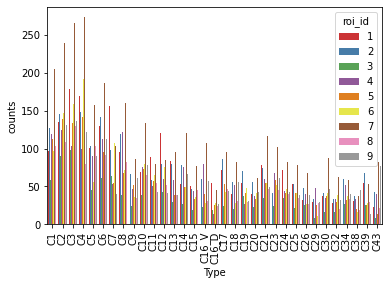

In [24]:
#Get counts for each type in each ROI
cmap=plt.get_cmap('Set1')
df = adata.obs
counts_df = []
examples = [[3,0,0],[3,1,0],[5,0,0],[5,1,0],[5,1,1],[5,1,2],[7,0,0],[7,1,0],[16,3,0]]
ROI_TO_ID = {"rn16_rg3_ex0":1,"rn3_rg0_ex0":2,"rn3_rg1_ex0":3,"rn5_rg0_ex0":4,"rn5_rg1_ex0":5,"rn5_rg1_ex1":6,"rn5_rg1_ex2":7,"rn7_rg0_ex0":8,"rn7_rg1_ex0":9}
id_cmap = {i+1:cmap(i) for i in range(len(ROI_TO_ID))}
for run,region,ex in examples:
    sample_poly = sg.Polygon(good_ROI[run][region][ex])
    xl,yl,xu,yu = np.round(list(sample_poly.bounds))

    #First, get counts without removing filters
    filt = (df['class']=='RGC') & df['realigned_center_x'].between(xl,xu) & df['realigned_center_y'].between(yl,yu) & (df['region']==region) &(df['run']==run) 
    df_s = df[filt]
    #sns.scatterplot(df_s,x='realigned_center_x',y='realigned_center_y',hue='Keep',s=1)
    df_s['final_assignment'] = df_s['final_assignment'].astype(str)
    c_df = df_s['final_assignment'].value_counts().reset_index(name='counts')
    c_df['roi_id'] = ROI_TO_ID["rn{}_rg{}_ex{}".format(run,region,ex)]

    #Second, get counts with removing filters
    df_s = df[filt & df['Keep']]
    df_s['final_assignment'] = df_s['final_assignment'].astype(str)
    c_df2 = df_s['final_assignment'].value_counts().reset_index(name='filt_counts')
    c_df2['roi_id'] = ROI_TO_ID["rn{}_rg{}_ex{}".format(run,region,ex)]

    c_df = c_df2.merge(c_df,on=['roi_id','index'])

    counts_df.append(c_df)
    plt.show()


counts_df = pd.concat(counts_df,ignore_index=True)
counts_df.rename(columns={'index':'Type'},inplace=True) 

sns.barplot(counts_df[~counts_df['Type'].isin(['Amacrine','Non-neuronal','Low quality neuronal','SAC'])],x='Type',y='counts',hue='roi_id',palette=id_cmap,order=['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'C15', 'C16_V', 'C16_D', 'C17', 'C18', 'C19', 'C20', 'C21', 'C23', 'C24', 'C25', 'C26', 'C29', 'C30', 'C32', 'C34', 'C38', 'C39', 'C43'])
plt.xticks(rotation=90)


In [25]:

def plot_null(trial,order,output_f):
    df_t = pd.read_csv(os.path.join(MOSAIC_DATA_DIR,"NNRIS_recalc_{}.csv".format(trial)),index_col=0)
    df_t.replace([np.inf],np.nan,inplace=True)
    df_t = df_t[~pd.isna(df_t['NNRI'])]

    df_t = df_t[df_t['Type'].isin(order) & df_t['Category'].isin(['Null'])]
    with plt.rc_context({'figure.dpi':200,'font.size':8,'font.sans-serif':'Arial','figure.figsize':(6,3)}):
        sns.barplot(df_t,x='Type',y='NNRI',hue='roi',order=order, capsize=0.25,edgecolor=None,errorbar='sd',err_kws={'linewidth':0.25})
        plt.xticks(rotation=90)
        plt.ylim(0,4)
        plt.savefig(output_f)
        return df_t


def plot_null_box(trial,order,output_f,filt_pairs=None):
    df_t = pd.read_csv(os.path.join(MOSAIC_DATA_DIR,"NNRIS_recalc_{}.csv".format(trial)),index_col=0)
    df_t.replace([np.inf],np.nan,inplace=True)
    df_t = df_t[~pd.isna(df_t['NNRI'])]
    df_t['roi_id'] = df_t['roi'].map(ROI_TO_ID)

    df_t = df_t[df_t['Type'].isin(order) & df_t['Category'].isin(['Null'])]
    if filt_pairs is not None:
        df_t['filt_col'] = df_t['roi_id'].astype(str) + "_" + df_t['Type']
        df_t = df_t[~df_t['filt_col'].isin(filt_pairs)]
    
    with plt.rc_context({'figure.dpi':200,'font.size':8,'font.sans-serif':'Arial','figure.figsize':(8,3)}):
        sns.boxplot(df_t,x='Type',y='NNRI',hue='roi_id',order=order,fliersize=0,linewidth=0.25,palette=id_cmap)
        plt.ylabel('Null NNRI')
        plt.xticks(rotation=90)
        plt.ylim(0,4)
        plt.savefig(output_f)
        return df_t
    




In [ ]:
df_t = plot_null_box('filt3_exclude_boundary',order=order,output_f=os.path.join(REVIEWER_DIR,"mosaic","DUMMY.pdf"))

In [ ]:
med_NNRI = pd.DataFrame(df_t.groupby(['roi_id','Type'])['NNRI'].agg(['median','std']).reset_index())
joined_df = med_NNRI.merge(counts_df,on=['roi_id','Type'])

for roi_id in range(1,10):
    sns.scatterplot(joined_df[joined_df['roi_id'].isin([roi_id])],x='counts',y='median')
    plt.ylabel('Median Null NNRI')
    plt.xlabel('Number of cells')
    plt.title(roi_id)
    plt.ylim(1.6,2.4)
    plt.xlim(0,200)
    plt.axvline(20)
    plt.show()

In [28]:
filt_df = joined_df[joined_df['counts']<20]
filt_df['pair'] = filt_df['roi_id'].astype(str) + "_" + filt_df['Type']

/var/folders/b3/jkbfjl310vdb0w4vhhz87pdr0000gn/T/ipykernel_3010/870067888.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filt_df['pair'] = filt_df['roi_id'].astype(str) + "_" + filt_df['Type']


In [ ]:
_ = plot_null_box('filt3_exclude_boundary',order=order,output_f=os.path.join(REVIEWER_DIR,"mosaic","null_nnri_per_roi_boxplot_ALL.pdf"),filt_pairs=filt_df['pair'].values)
plt.show()
_ = plot_null_box('filt3_exclude_boundary',order=suborder,output_f=os.path.join(REVIEWER_DIR,"mosaic","null_nnri_per_roi_boxplot_subset.pdf"),filt_pairs=filt_df['pair'].values)

In [38]:
TRIAL_MAP = {
    'filt3_exclude_boundary':'1 z-section (no artifact removal)', 
    'filt2_exclude_boundary':'2D-modified (with artifact removal)',
    'filt1_exclude_boundary':'2D-modified (no artifact removal)',
    'final_v2':'Original (with artifact removal)',
    'final_v3':'Original (with artifact removal)',
    'nofilt_exclude_boundary':'Original without artifact removal',
    'filt1_mixtures':'Mixture Types'
    }

cmap_s1 = plt.get_cmap('Set1')
TRIAL_COLORS = {
    '1 z-section (no artifact removal)':cmap_s1(0), 
    '2D-modified (with artifact removal)':cmap_s1(4),
    '2D-modified (no artifact removal)':cmap_s1(3),
    'Original (with artifact removal)':cmap_s1(1),
    'Original without artifact removal':cmap_s1(2),
    'Mixture Types':cmap_s1(5)
}

In [39]:
figure_dir=os.path.join("..","intermediate_figures","mosaic","new_figures")
trials = ["filt2_exclude_boundary","filt1_exclude_boundary","filt3_exclude_boundary","nofilt_exclude_boundary","final_v3"]
exclude_bad_triples = False
do_diagnostic=False

def make_percentile_plots(trial,trial_map,trial_color,exclude_bad_triples,do_diagnostic,figure_dir,output_f=None,order=None,filt_pairs=None,ri_key='NNRI'):
    # df_NNRI = pd.read_csv(os.path.join(MOSAIC_DATA_DIR,'NNRI_{}.csv'.format(trial)))
    # if not os.path.exists(figure_dir):
    #     print("Making", figure_dir)
    #     os.mkdir(figure_dir)


    df_t = pd.read_csv(os.path.join(MOSAIC_DATA_DIR,"{}S_recalc_{}.csv".format(ri_key,trial)),index_col=0)
    df_t.replace([np.inf],np.nan,inplace=True)
    df_t = df_t[~pd.isna(df_t[ri_key])]
    
    if filt_pairs is not None:
        df_t['roi_id'] = df_t['roi'].map(ROI_TO_ID)
        df_t['filt_col'] = df_t['roi_id'].astype(str) + "_" + df_t['Type']
        df_t = df_t[~df_t['filt_col'].isin(filt_pairs)]
        
    
    if exclude_bad_triples:
        bad_triples = df_t[(df_t[ri_key]>np.percentile(df_t[ri_key],99.9)) & df_t['Type'].isin(['C43','C29'])].drop_duplicates(subset=['Type','roi','Category'])[['roi','Category','Type']].values
        bad_triples = [tuple(x) for x in bad_triples]
        bad_triples.extend([ (roi,'Observed',ct) for roi,cat,ct in bad_triples])
        df_t= df_t[~df_t[['roi','Category','Type']].apply(tuple,axis=1).isin(bad_triples)]

        
    t_counts = adata.obs['final_assignment'].value_counts()
    valid_types = t_counts[t_counts > 1900].index

    if order is None:
        order = ['SAC'] + [t for t in df_NNRI['Type'].unique()[2:] if t in valid_types]

    if do_diagnostic:
        for i in range(0,len(order),9):
            diagnostic(df_t,order=order[i:i+9],figure_dir=figure_dir,output_f1=f"filt_NNRI_per_roi_comparisons_{trial}_group{i}.pdf")
            pass
    
    
    #adjusted_ps = []
    all_ps = []

    for ctype in order:
        df_st = df_t[df_t['Type'] == ctype]
        p_vals = []
        for roi in df_st['roi'].unique():
            scores = df_st[(df_st['Category']=='Null') & (df_st['roi']==roi)][ri_key].values
            observations = df_st[(df_st['Category']=='Observed') & (df_st['roi']==roi)][ri_key].values
            if len(observations) > 0:
                p_val = np.sum(scores > observations)/len(scores)
                p_vals.append(p_val)
        all_ps.append(p_vals)
        #adjusted_ps.append(scipy.stats.combine_pvalues(p_vals,method='fisher').pvalue)




    df_p = pd.DataFrame({'Type':order,'p_val':all_ps}).explode(['p_val'])
    df_p['Percentile'] = 1-df_p['p_val']

    df_p = df_p.reset_index()
    title = trial_map[trial]
    
    
    with plt.rc_context({'figure.dpi':200,'font.sans-serif':'Arial','font.size':8}):
        fig,ax= plt.subplots(ncols=2,figsize=(9.25,1.5)) 
        fig.suptitle(title)

        sns.barplot(df_p,x='Type',y='Percentile',order=df_p.groupby(['Type'])['Percentile'].mean().sort_values(ascending=False).index,errorbar=None,color=trial_color[trial_map[trial]],edgecolor='black',linewidth=0.25,ax=ax[1])
        sns.stripplot(df_p,x='Type',y='Percentile',order=df_p.groupby(['Type'])['Percentile'].mean().sort_values(ascending=False).index,s=2,color='black',ax=ax[1])
        ax[1].tick_params(axis='x',rotation=90)
        ax[1].set_ylabel('Percentile compared to null')
    
        plot_data = {
                'data':df_t,
                'x':'Type',
                'hue':'Category',
                'y':ri_key,
                'palette':{'Null':'Grey','Observed':trial_color[trial_map[trial]]},
                'err_kws':{'linewidth':0.5,'color':'black'},
                'capsize':0.5,
                'edgecolor':'black',
                'linewidth':0.25,
                'errorbar':'sd',
                'order':order,
                'ax':ax[0]
            
            
            }

        sns.barplot(**plot_data)
        ax[0].set_ylim(0,6)
        ax[0].tick_params(axis='x',rotation=90)
        if output_f is None:
            output_f = os.path.join(figure_dir,"Avg_percentile_and_{}_barplot_{}_all.pdf".format(key,trial))
        else:
            output_f = os.path.join(figure_dir,output_f)
        print("Saving to {}".format(output_f))
        fig.savefig(output_f)
        fig.show()


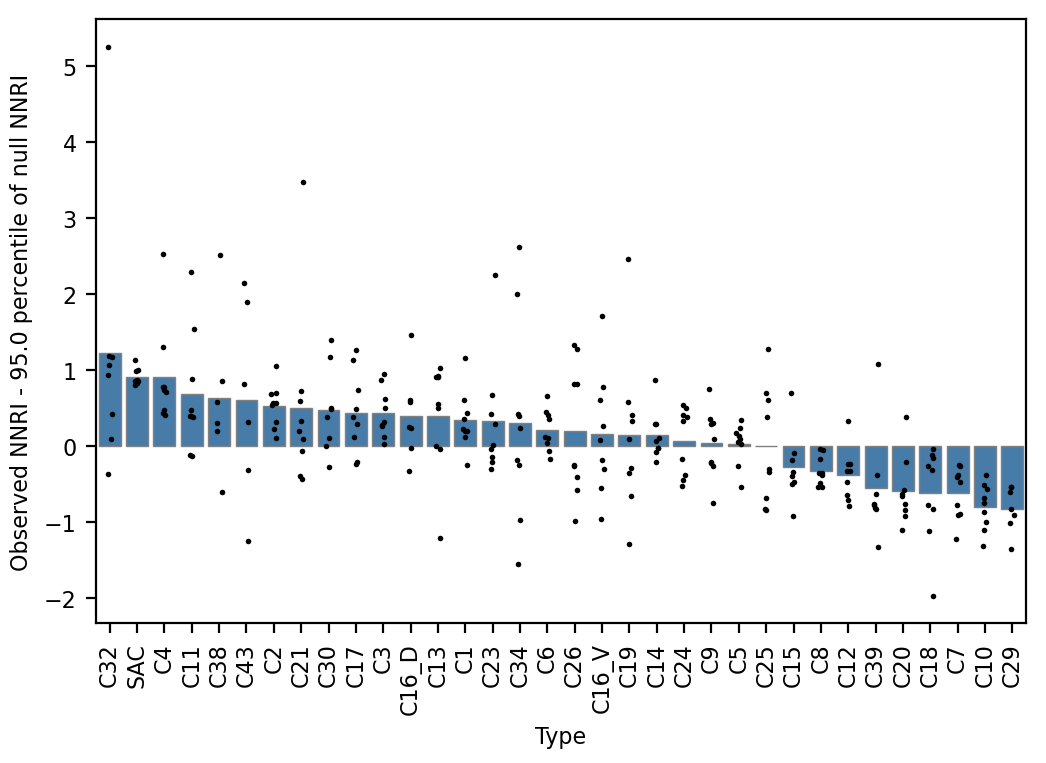

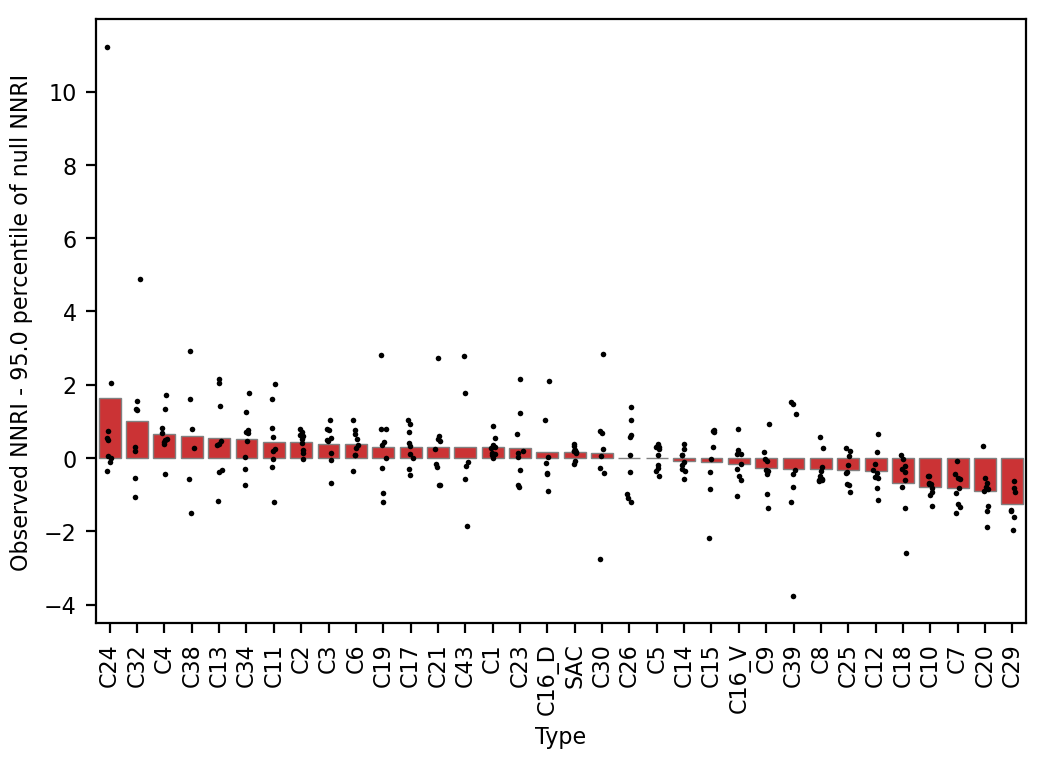

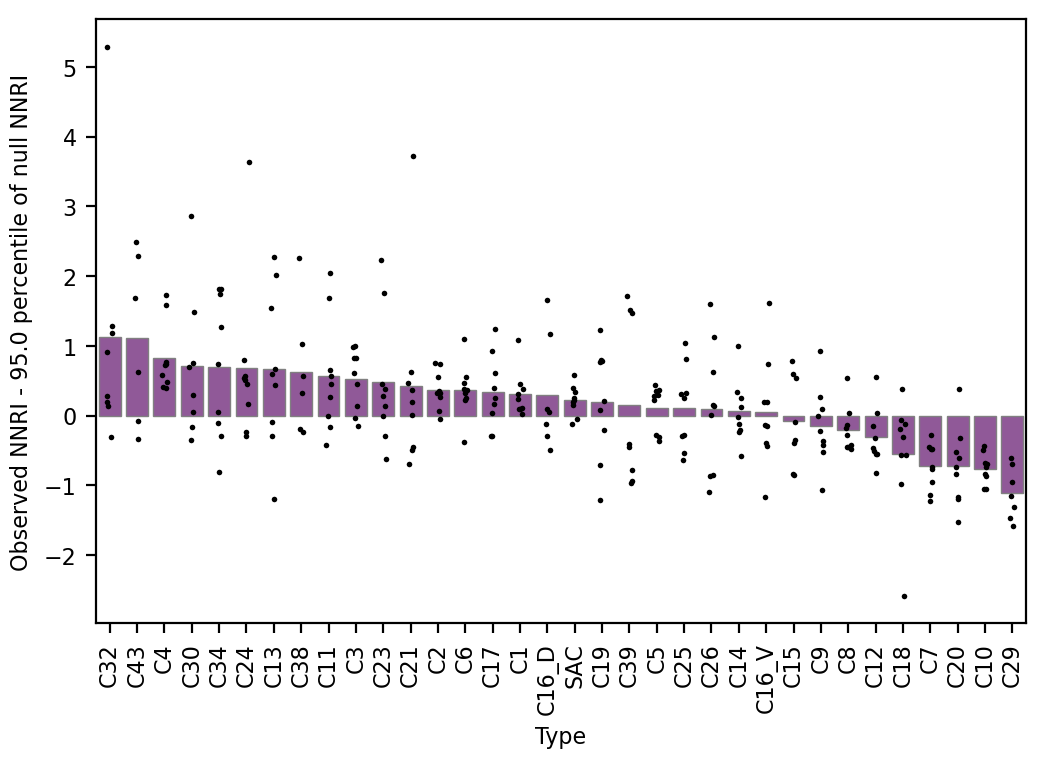

In [40]:
order = ['SAC'] + [f'C{i}'.format(i) for i in range(1,16)] + ['C16_V','C16_D'] + [f'C{i}'.format(i) for i in range(17,44)] + ['C45']
suborder = ['SAC', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'C15', 'C16_V', 'C16_D', 'C17', 'C18', 'C19', 'C20', 'C21', 'C23', 'C24', 'C25', 'C26', 'C29', 'C30', 'C32', 'C34', 'C38', 'C39', 'C43']
rem_order = [x for x in order if x not in suborder]
trial_subset =['final_v3', 'filt3_exclude_boundary','filt1_exclude_boundary']

def make_magnitude_plots(trial,trial_map,trial_color,quantile,figure_dir,output_f,ok_types,filt_pairs=None):
    df_t = pd.read_csv(os.path.join(MOSAIC_DATA_DIR,"NNRIS_recalc_{}.csv".format(trial)),index_col=0)
    df_t.replace([np.inf],np.nan,inplace=True)
    df_t = df_t[~pd.isna(df_t['NNRI'])]
    
    if filt_pairs is not None:
        df_t['roi_id'] = df_t['roi'].map(ROI_TO_ID)
        df_t['filt_col'] = df_t['roi_id'].astype(str) + "_" + df_t['Type']
        df_t = df_t[~df_t['filt_col'].isin(filt_pairs)]
        
    null_percentiles = pd.DataFrame(df_t[df_t['Category']=='Null'].groupby(['roi','Type'])['NNRI'].quantile(quantile))
    deviations = df_t[df_t['Category']=='Observed'][['roi','Type','NNRI']].set_index(['roi','Type']) - null_percentiles

    k = f'Observed NNRI - {quantile*100} percentile of null NNRI'
    dev_df = deviations.reset_index().rename(columns={'NNRI':k})
    dev_df = dev_df[dev_df['Type'].isin(ok_types)]
    order = dev_df.groupby('Type')[k].mean().sort_values(ascending=False).index
    with plt.rc_context({'figure.dpi':200,'font.sans-serif':'Arial','font.size':8}):
        sns.barplot(dev_df,x='Type',y=k,order=order,errorbar=None,color=trial_color[trial_map[trial]],edgecolor='grey',linewidth=0.5)
        sns.stripplot(dev_df,x='Type',y=k,order=order,s=2,color='black')
        plt.xticks(rotation=90);
        plt.savefig(os.path.join(figure_dir,output_f))

%matplotlib inline
for trial in trial_subset:
    make_magnitude_plots(trial=trial,trial_map = TRIAL_MAP,trial_color=TRIAL_COLORS,ok_types=suborder,quantile=0.95,figure_dir=os.path.join("..","..","reviewer_figs","mosaic"),output_f="NNRI_95th_vs_median_{}.pdf".format(trial),filt_pairs=filt_df['pair'].values)
    plt.show()


Saving to ../../reviewer_figs/mosaic/Avg_percentile_and_NNRI_barplot_filt1_exclude_boundary_suborder_v2.pdf


/var/folders/b3/jkbfjl310vdb0w4vhhz87pdr0000gn/T/ipykernel_30460/1636203408.py:102: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


Saving to ../../reviewer_figs/mosaic/Avg_percentile_and_VDRI_barplot_filt1_exclude_boundary_suborder_v2.pdf


/var/folders/b3/jkbfjl310vdb0w4vhhz87pdr0000gn/T/ipykernel_30460/1636203408.py:102: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


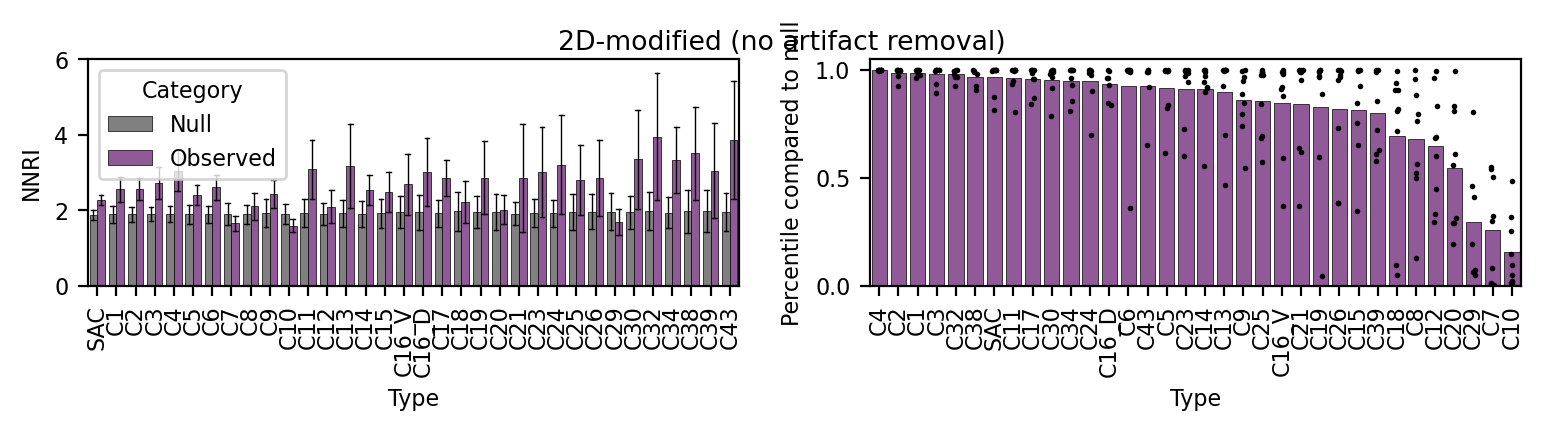

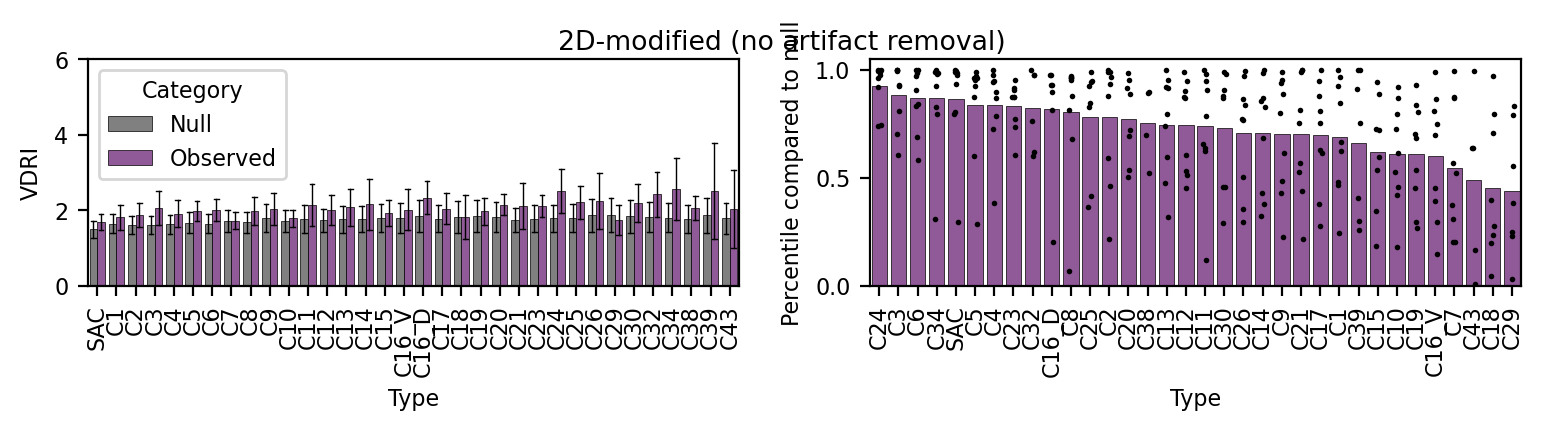

In [17]:
order = ['SAC'] + [f'C{i}'.format(i) for i in range(1,16)] + ['C16_V','C16_D'] + [f'C{i}'.format(i) for i in range(17,44)] + ['C45']
suborder = ['SAC', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'C15', 'C16_V', 'C16_D', 'C17', 'C18', 'C19', 'C20', 'C21', 'C23', 'C24', 'C25', 'C26', 'C29', 'C30', 'C32', 'C34', 'C38', 'C39', 'C43']
rem_order = [x for x in order if x not in suborder]
#trial_subset =['final_v3', 'filt3_exclude_boundary','filt1_exclude_boundary']
trial_subset = ['filt1_exclude_boundary']
for trial in trial_subset:
    #df_p = make_percentile_plots(trial=trial,trial_map = TRIAL_MAP,trial_color=TRIAL_COLORS, exclude_bad_triples=False,do_diagnostic=False,order=rem_order,figure_dir=os.path.join("..","..","reviewer_figs","mosaic"),output_f="Avg_percentile_and_NNRI_barplot_{}_bad_types.pdf".format(trial),filt_pairs=filt_df['pair'].values)
    df_p = make_percentile_plots(trial=trial,trial_map = TRIAL_MAP,trial_color=TRIAL_COLORS, exclude_bad_triples=False,do_diagnostic=False,order=suborder,figure_dir=os.path.join("..","..","reviewer_figs","mosaic"),output_f="Avg_percentile_and_NNRI_barplot_{}_suborder_v2.pdf".format(trial),filt_pairs=filt_df['pair'].values)
    df_p = make_percentile_plots(trial=trial,trial_map = TRIAL_MAP,trial_color=TRIAL_COLORS, exclude_bad_triples=False,do_diagnostic=False,order=suborder,figure_dir=os.path.join("..","..","reviewer_figs","mosaic"),output_f="Avg_percentile_and_VDRI_barplot_{}_suborder_v2.pdf".format(trial),filt_pairs=filt_df['pair'].values,ri_key='VDRI')
    #df_p = make_percentile_plots(trial=trial,trial_map = TRIAL_MAP,trial_color=TRIAL_COLORS, exclude_bad_triples=False,do_diagnostic=False,order=order,figure_dir=os.path.join("..","..","reviewer_figs","mosaic"),output_f="Avg_percentile_and_NNRI_barplot_{}_order_v2.pdf".format(trial),filt_pairs=filt_df['pair'].values)   

Saving to ../../reviewer_figs/mosaic/Avg_percentile_and_VDRI_barplot_filt1_exclude_boundary_suborder_v2.pdf


/var/folders/b3/jkbfjl310vdb0w4vhhz87pdr0000gn/T/ipykernel_3010/1636203408.py:102: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


Saving to ../../reviewer_figs/mosaic/Avg_percentile_and_VDRI_barplot_final_v2_suborder_v2.pdf


/var/folders/b3/jkbfjl310vdb0w4vhhz87pdr0000gn/T/ipykernel_3010/1636203408.py:102: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


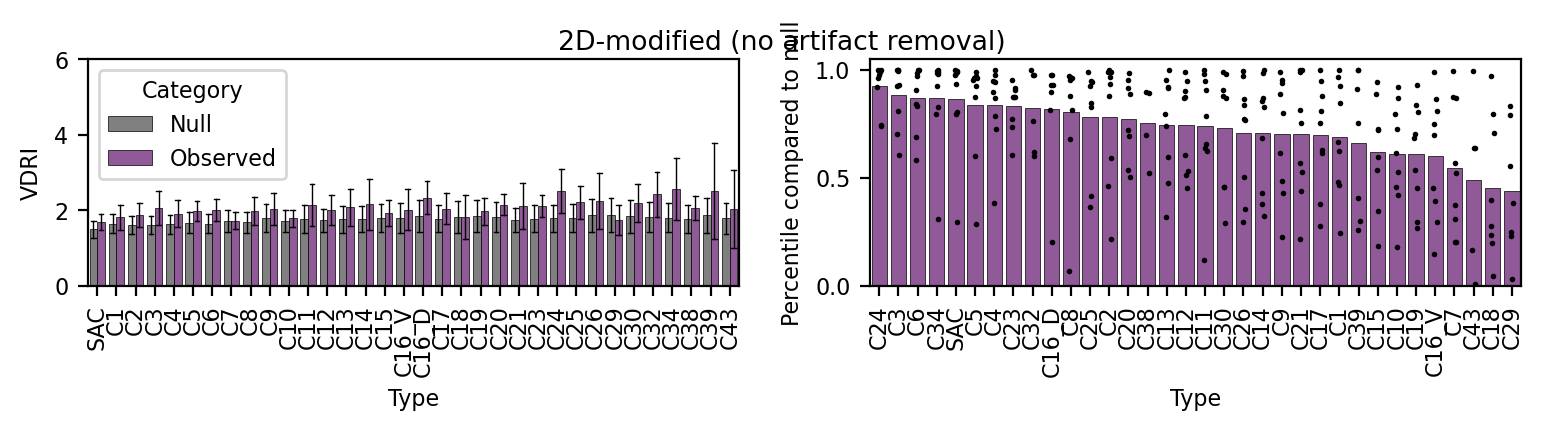

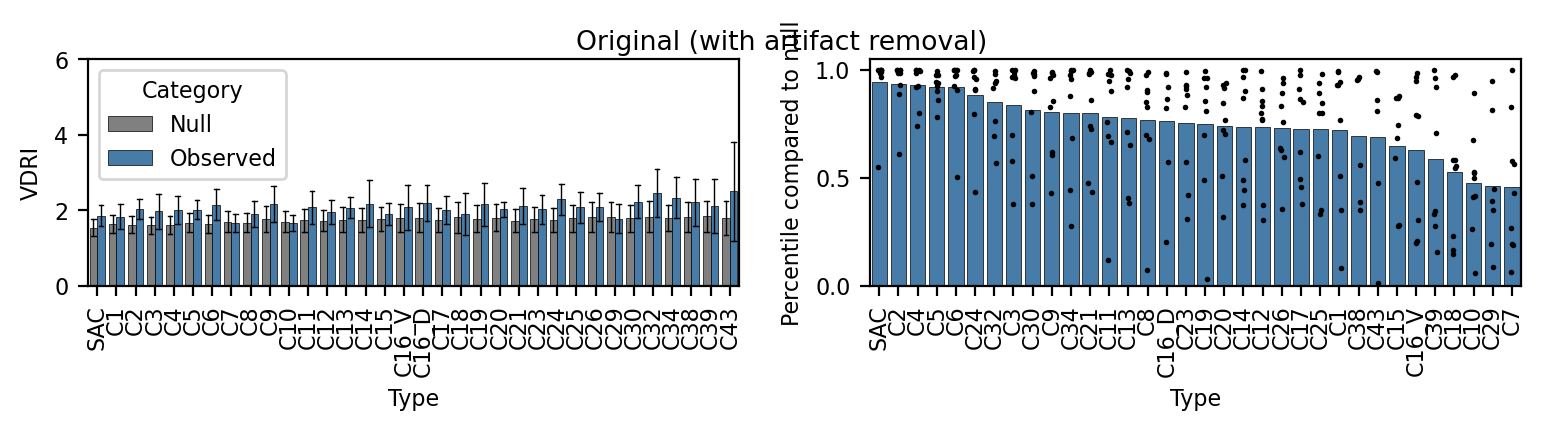

In [41]:
order = ['SAC'] + [f'C{i}'.format(i) for i in range(1,16)] + ['C16_V','C16_D'] + [f'C{i}'.format(i) for i in range(17,44)] + ['C45']
suborder = ['SAC', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'C15', 'C16_V', 'C16_D', 'C17', 'C18', 'C19', 'C20', 'C21', 'C23', 'C24', 'C25', 'C26', 'C29', 'C30', 'C32', 'C34', 'C38', 'C39', 'C43']
rem_order = [x for x in order if x not in suborder]
#trial_subset =['final_v3', 'filt3_exclude_boundary','filt1_exclude_boundary']
trial_subset = ['filt1_exclude_boundary','final_v2']
for trial in trial_subset:
    #df_p = make_percentile_plots(trial=trial,trial_map = TRIAL_MAP,trial_color=TRIAL_COLORS, exclude_bad_triples=False,do_diagnostic=False,order=rem_order,figure_dir=os.path.join("..","..","reviewer_figs","mosaic"),output_f="Avg_percentile_and_NNRI_barplot_{}_bad_types.pdf".format(trial),filt_pairs=filt_df['pair'].values)
    #df_p = make_percentile_plots(trial=trial,trial_map = TRIAL_MAP,trial_color=TRIAL_COLORS, exclude_bad_triples=False,do_diagnostic=False,order=suborder,figure_dir=os.path.join("..","..","reviewer_figs","mosaic"),output_f="Avg_percentile_and_NNRI_barplot_{}_suborder_v2.pdf".format(trial),filt_pairs=filt_df['pair'].values)
    df_p = make_percentile_plots(trial=trial,trial_map = TRIAL_MAP,trial_color=TRIAL_COLORS, exclude_bad_triples=False,do_diagnostic=False,order=suborder,figure_dir=os.path.join("..","..","reviewer_figs","mosaic"),output_f="Avg_percentile_and_VDRI_barplot_{}_suborder_v2.pdf".format(trial),filt_pairs=filt_df['pair'].values,ri_key='VDRI')
    #df_p = make_percentile_plots(trial=trial,trial_map = TRIAL_MAP,trial_color=TRIAL_COLORS, exclude_bad_triples=False,do_diagnostic=False,order=order,figure_dir=os.path.join("..","..","reviewer_figs","mosaic"),output_f="Avg_percentile_and_NNRI_barplot_{}_order_v2.pdf".format(trial),filt_pairs=filt_df['pair'].values)   

In [42]:
figure_dir=os.path.join("..","intermediate_figures","mosaic","new_figures")
trials = ["filt2_exclude_boundary","filt1_exclude_boundary","filt3_exclude_boundary","nofilt_exclude_boundary","final_v3"]
exclude_bad_triples = False
do_diagnostic=False

import scipy

def make_joint_p(trials,trial_map,exclude_bad_triples,do_diagnostic,figure_dir,order=None,filt_pairs=None,ri_key='NNRI'):
    df_joint_p = []
    for trial in trials:
        # df_NNRI = pd.read_csv(os.path.join(MOSAIC_DATA_DIR,'{}_{}.csv'.format(ri_key,trial)))
        # figure_dir=os.path.join("..","intermediate_figures","mosaic",trial)
        # if not os.path.exists(figure_dir):
        #     print("Making", figure_dir)
        #     os.mkdir(figure_dir)


        df_t = pd.read_csv(os.path.join(MOSAIC_DATA_DIR,"{}S_recalc_{}.csv".format(ri_key,trial)),index_col=0)
        df_t.replace([np.inf],np.nan,inplace=True)
        df_t = df_t[~pd.isna(df_t[ri_key])]
        
        if exclude_bad_triples:
            bad_triples = df_t[(df_t[ri_key]>np.percentile(df_t[ri_key],99.9)) & df_t['Type'].isin(['C43','C29'])].drop_duplicates(subset=['Type','roi','Category'])[['roi','Category','Type']].values
            bad_triples = [tuple(x) for x in bad_triples]
            bad_triples.extend([ (roi,'Observed',ct) for roi,cat,ct in bad_triples])
            df_t= df_t[~df_t[['roi','Category','Type']].apply(tuple,axis=1).isin(bad_triples)]
        
        if filt_pairs is not None:
            df_t['roi_id'] = df_t['roi'].map(ROI_TO_ID)
            df_t['filt_col'] = df_t['roi_id'].astype(str) + "_" + df_t['Type']
            df_t = df_t[~df_t['filt_col'].isin(filt_pairs)]
            
        t_counts = adata.obs['final_assignment'].value_counts()
        valid_types = t_counts[t_counts > 1900].index

        if order is None:
            order = ['SAC'] + [t for t in df_NNRI['Type'].unique()[2:] if t in valid_types]

        all_ps = []

        for ctype in order:
            df_st = df_t[df_t['Type'] == ctype]
            p_vals = []
            for roi in df_st['roi'].unique():
                scores = df_st[(df_st['Category']=='Null') & (df_st['roi']==roi)][ri_key].values
                observations = df_st[(df_st['Category']=='Observed') & (df_st['roi']==roi)][ri_key].values
                if len(observations) > 0:
                    p_val = np.sum(scores > observations)/len(scores)
                    p_vals.append(p_val)
            all_ps.append(p_vals)
            #adjusted_ps.append(scipy.stats.combine_pvalues(p_vals,method='fisher').pvalue)




        df_p = pd.DataFrame({'Type':order,'p_val':all_ps}).explode(['p_val'])
        df_p['Percentile'] = 1-df_p['p_val']

        if trial_map is None:
            title = trial
        else:
            title = trial_map[trial]
        
        df_p['trial_name']= title
        df_joint_p.append(df_p)
    
    return pd.concat(df_joint_p,ignore_index=True)
    
def adjust_p(df_jp,eps=0.0005,mult_correct=False):
    df_jp['p_val_eps'] = df_jp['p_val']+eps 
    grouped_p_s = df_jp.groupby(['Type','trial_name'])['p_val_eps'].apply(list)
    #grouped_p_v = np.vstack(grouped_p_s[:]).astype(float)
    p_output = []
    for i,p_values in enumerate(grouped_p_s):
        p_output.append(scipy.stats.combine_pvalues(p_values,method='fisher').pvalue)
        #print(p_values,grouped_p_s.index[i])
    
    if mult_correct:
        print(p_output)
        p_output = scipy.stats.false_discovery_control(p_output)
    updated_p_s = pd.Series(index=grouped_p_s.index,data=p_output)
    df = updated_p_s.reset_index(name='Adjusted p-value')
    df['-log10 p'] = -np.log10(df['Adjusted p-value'])

    return df
        


In [19]:
#trial_subset =['final_v3', 'filt3_exclude_boundary','filt1_exclude_boundary']
trial_subset =['filt1_exclude_boundary','filt3_exclude_boundary']
df_jp = make_joint_p(trials=trial_subset,trial_map = TRIAL_MAP,exclude_bad_triples=False,do_diagnostic=False,order=suborder,figure_dir=os.path.join("..","intermediate_figures","mosaic","new_figures"),filt_pairs=filt_df['pair'].values,ri_key='NNRI')
df= adjust_p(df_jp,mult_correct=True)
#order = ['SAC', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'C15', 'C16_V', 'C16_D', 'C17', 'C18', 'C19', 'C20', 'C21', 'C23', 'C24', 'C25', 'C26', 'C29', 'C30', 'C32', 'C34', 'C38', 'C39', 'C43']
#order = ['SAC'] + [f'C{i}'.format(i) for i in range(1,16)] + ['C16_V','C16_D'] + [f'C{i}'.format(i) for i in range(17,46)]



[2.739327899339823e-12, 9.84372905154687e-12, 0.9995887008159082, 0.9999352423623077, 1.9631959397409463e-10, 5.914062542699017e-12, 0.035833258588637694, 0.04558998412974074, 3.5346005767614437e-10, 3.802356540169166e-12, 9.23678826596438e-05, 3.657546801655846e-07, 7.645424134210462e-06, 2.8987524224353626e-05, 6.207710775230391e-05, 4.1616766730419e-06, 0.0001697360207538902, 3.3162533393711044e-06, 1.181274134034073e-09, 1.2534477703765392e-10, 0.034834118100237434, 0.010825781774173964, 8.901616962316226e-07, 2.3955455154385417e-07, 1.337041716735088e-15, 1.7016096333005583e-14, 0.2522693353911258, 0.18985545520873787, 5.9477596860595574e-08, 6.299141764211711e-08, 8.979781156070707e-07, 1.1596923364270324e-08, 5.228487106469762e-10, 2.546494372393425e-10, 0.002944559636848666, 1.8088937058785327e-05, 3.184443152505968e-06, 1.7700764963939464e-06, 0.9481759534474966, 0.9571141090646347, 5.060925586332376e-14, 6.756527289732973e-15, 2.730613877706959e-07, 1.5444130295486935e-08, 6.

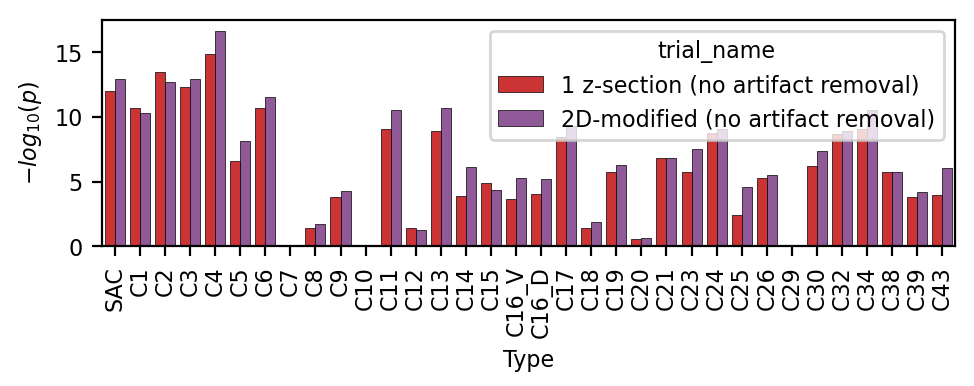

In [20]:
%matplotlib inline
with plt.rc_context({'figure.dpi':200,'font.sans-serif':'Arial','font.size':8,'figure.figsize':(5.5,1.5)}):
    
    sns.barplot(df,x='Type',hue='trial_name',y='-log10 p',order=suborder,palette=TRIAL_COLORS,edgecolor='black',linewidth=0.25)
    plt.ylabel(r'$-log_{10}(p)$')
    plt.xticks(rotation=90);
    plt.savefig(os.path.join(REVIEWER_DIR,"mosaic","adjusted_p_values_NNRI_2.pdf"))

[0.009759994999089324, 0.0013313780791942374, 0.2822671728124, 0.7328603990301783, 0.0007583267247653207, 0.00010950900789747114, 0.011720268965573512, 0.016210010037426132, 0.0015079156403529712, 4.7170926292030415e-05, 0.0019511712611734189, 0.00015173898501083828, 0.23197081691927027, 0.20111145381334455, 0.0021376161278033484, 0.005865743683600957, 0.1408932468950342, 0.034360487423208776, 0.005333104034781255, 0.0017755792335825621, 0.5010970435218933, 0.23796284974496648, 0.2821800567174827, 0.002750455517046821, 2.042919204566689e-05, 7.282977538165666e-11, 0.011266706981609666, 0.03988701957860567, 5.438917053960356e-05, 3.562492451855982e-05, 0.007807261423280384, 0.007724455279072907, 8.781451146354587e-09, 3.1720014296233287e-07, 0.0036817882094526905, 0.02418612585214233, 0.01150862631914868, 0.04301463928408857, 0.73116927579809, 0.532112882186389, 7.728465871687696e-09, 2.763924483773092e-07, 0.006007307817313847, 0.00022965764601067657, 0.0008684101354416972, 0.000474465

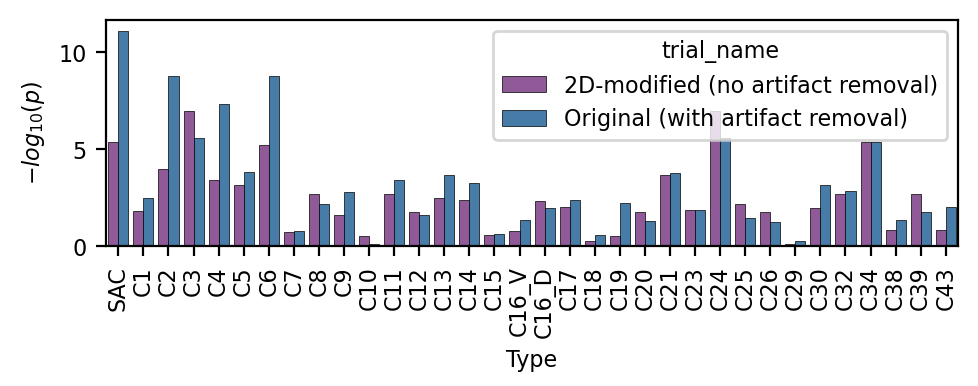

In [43]:
#trial_subset =['final_v3', 'filt3_exclude_boundary','filt1_exclude_boundary']
trial_subset =['filt1_exclude_boundary','final_v2']
df_jp = make_joint_p(trials=trial_subset,trial_map = TRIAL_MAP,exclude_bad_triples=False,do_diagnostic=False,order=suborder,figure_dir=os.path.join("..","intermediate_figures","mosaic","new_figures"),filt_pairs=filt_df['pair'].values,ri_key='VDRI')
df= adjust_p(df_jp,mult_correct=True)
#order = ['SAC', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'C15', 'C16_V', 'C16_D', 'C17', 'C18', 'C19', 'C20', 'C21', 'C23', 'C24', 'C25', 'C26', 'C29', 'C30', 'C32', 'C34', 'C38', 'C39', 'C43']
#order = ['SAC'] + [f'C{i}'.format(i) for i in range(1,16)] + ['C16_V','C16_D'] + [f'C{i}'.format(i) for i in range(17,46)]

%matplotlib inline
with plt.rc_context({'figure.dpi':200,'font.sans-serif':'Arial','font.size':8,'figure.figsize':(5.5,1.5)}):
    
    sns.barplot(df,x='Type',hue='trial_name',y='-log10 p',order=suborder,palette=TRIAL_COLORS,edgecolor='black',linewidth=0.25)
    plt.ylabel(r'$-log_{10}(p)$')
    plt.xticks(rotation=90);
    plt.savefig(os.path.join(REVIEWER_DIR,"mosaic","adjusted_p_values_VDRI_2.pdf"))

In [48]:
from statannotations.Annotator import Annotator
def quant_mosaic(df_RI,types,type_col='Type',cat_col='Category',score_col='NNRI',color='cornflowerblue',test='Mann-Whitney',pairs=None,p_vals=None,correction='BH',figsize=(9,3),ylim=(0,4),output_f=""):
    statistics = []
    if pairs is None:
        pairs = []
        for rt in types:
            subgroups = []
            for cat in df_RI[cat_col].unique():
                subgroups.append((rt,cat))
            pairs.append(subgroups)
        
        pairs=  tuple(pairs)
    print(pairs)
    with plt.rc_context({"figure.figsize":figsize,"figure.dpi":200,'font.size':8,'font.sans-serif':'Arial'}):
        df = df_RI[df_RI[type_col].isin(types)]
        plot_data = {
            'data':df,
            'x':'Type',
            'hue':'Category',
            'y':score_col,
            'palette':{'Null':'Grey','Observed':color},
            'err_kws':{'linewidth':0.5,'color':'black'},
            'capsize':0.5,
            'edgecolor':'black',
            'errorbar':'sd',
            'hue_order':['Null','Observed'],
            'order':types
        
        }
   
        print(pairs)
        ax = sns.barplot(**plot_data)


    with plt.rc_context({"figure.figsize":figsize,'figure.dpi':200,'font.size':8,'font.sans-serif':'Arial'}):
        annotator = Annotator(ax, pairs,plot='barplot',**plot_data)
        if p_vals is None:
            annotator.configure(test=test, verbose=False,line_width=0.5,comparisons_correction=correction)
            _, results = annotator.apply_and_annotate()
        else:
            print(len(p_vals),len(pairs))
            assert len(p_vals) == len(pairs)
            annotator.set_pvalues(p_vals)
            annotator.annotate()

        plt.xlabel('')
        plt.xticks(rotation=90)
        plt.xlim(-0.75,len(types)-0.25)
        plt.ylim(ylim)
        plt.savefig(output_f,bbox_inches='tight')
        plt.show()
        
    #return dict(zip(order,statistics))

In [50]:
def load_trial(trial,ri_key='VDRI',filt_pairs=None):
    df = pd.read_csv(os.path.join(MOSAIC_DATA_DIR,'{}S_recalc_{}.csv'.format(ri_key,trial)),index_col=0)
    df.replace([np.inf],np.nan,inplace=True)
    df = df[~pd.isna(df[ri_key])]
    #df['Type'] = pd.Categorical(df['Type'], categories=suborder, ordered=True)
    print(len(df))
    if filt_pairs is not None:
        df['roi_id'] = df['roi'].map(ROI_TO_ID)
        df['filt_col'] = df['roi_id'].astype(str) + "_" + df['Type']
        df= df[~df['filt_col'].isin(filt_pairs)]
    
    print(len(df))

    return df.sort_values(by='Type')

[0.009759994999089324, 0.2822671728124, 0.0007583267247653207, 0.011720268965573512, 0.0015079156403529712, 0.0019511712611734189, 0.23197081691927027, 0.0021376161278033484, 0.1408932468950342, 0.005333104034781255, 0.5010970435218933, 0.2821800567174827, 2.042919204566689e-05, 0.011266706981609666, 5.438917053960356e-05, 0.007807261423280384, 8.781451146354587e-09, 0.0036817882094526905, 0.01150862631914868, 0.73116927579809, 7.728465871687696e-09, 0.006007307817313847, 0.0008684101354416972, 5.816701497731003e-07, 0.11784793777316831, 0.0006951662304888018, 9.515466708246035e-05, 0.12360707874276748, 0.0002013174669364322, 1.0289542694822966e-06, 0.1546847384091836, 0.0007526335564449527, 0.017344036495403118, 6.988599207459916e-07]
154308
154308
([('SAC', 'Null'), ('SAC', 'Observed')], [('C1', 'Null'), ('C1', 'Observed')], [('C2', 'Null'), ('C2', 'Observed')], [('C3', 'Null'), ('C3', 'Observed')], [('C4', 'Null'), ('C4', 'Observed')], [('C5', 'Null'), ('C5', 'Observed')], [('C6', '

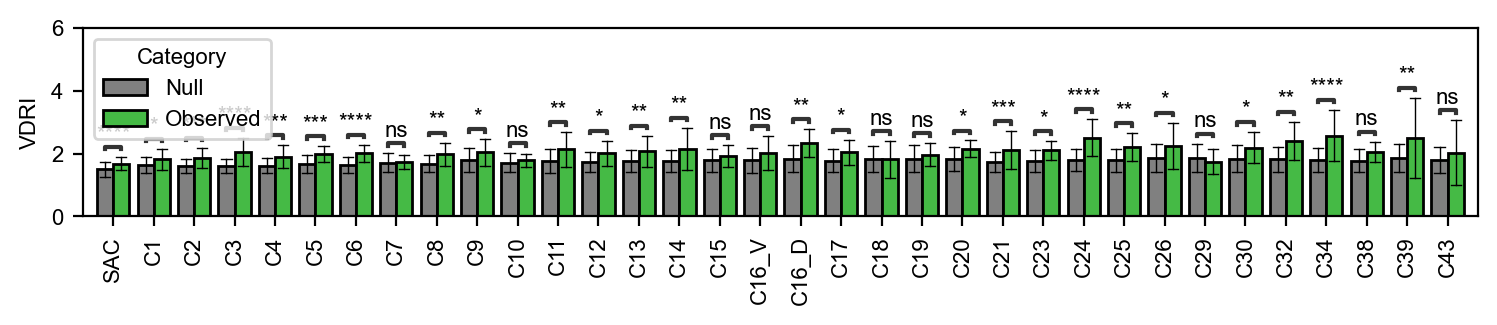

In [85]:


#trial_subset =['final_v3', 'filt3_exclude_boundary','filt1_exclude_boundary']
trial_subset =['filt1_exclude_boundary']

df_jp = make_joint_p(trials=trial_subset,trial_map = TRIAL_MAP,exclude_bad_triples=False,do_diagnostic=False,order=suborder,figure_dir=os.path.join("..","intermediate_figures","mosaic","new_figures"),filt_pairs=filt_df['pair'].values,ri_key='VDRI')
df= adjust_p(df_jp,mult_correct=True)
#order = ['SAC', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'C15', 'C16_V', 'C16_D', 'C17', 'C18', 'C19', 'C20', 'C21', 'C23', 'C24', 'C25', 'C26', 'C29', 'C30', 'C32', 'C34', 'C38', 'C39', 'C43']
#order = ['SAC'] + [f'C{i}'.format(i) for i in range(1,16)] + ['C16_V','C16_D'] + [f'C{i}'.format(i) for i in range(17,46)]


#df is p-values
df['Type'] = pd.Categorical(df['Type'],categories=suborder,ordered=True)
df= df.sort_values(by='Type')#VDRI already has filters
quant_mosaic(load_trial('filt1_exclude_boundary',filt_pairs=None),suborder,type_col='Type',score_col='VDRI',color='limegreen',figsize=(9,1.25),test=None,ylim=(0,6),p_vals=df['Adjusted p-value'].values,output_f=os.path.join(REVIEWER_DIR,"mosaic","VDRI_barplot.pdf"))

In [ ]:


#trial_subset =['final_v3', 'filt3_exclude_boundary','filt1_exclude_boundary']
trial_subset =['filt1_exclude_boundary']

df_jp = make_joint_p(trials=trial_subset,trial_map = TRIAL_MAP,exclude_bad_triples=False,do_diagnostic=False,order=suborder,figure_dir=os.path.join("..","intermediate_figures","mosaic","new_figures"),filt_pairs=filt_df['pair'].values,ri_key='NNRI')
df= adjust_p(df_jp,mult_correct=True)
#order = ['SAC', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'C15', 'C16_V', 'C16_D', 'C17', 'C18', 'C19', 'C20', 'C21', 'C23', 'C24', 'C25', 'C26', 'C29', 'C30', 'C32', 'C34', 'C38', 'C39', 'C43']
#order = ['SAC'] + [f'C{i}'.format(i) for i in range(1,16)] + ['C16_V','C16_D'] + [f'C{i}'.format(i) for i in range(17,46)]


#df is p-values
df['Type'] = pd.Categorical(df['Type'],categories=suborder,ordered=True)
df= df.sort_values(by='Type')#VDRI already has filters
quant_mosaic(load_trial('filt1_exclude_boundary',filt_pairs=None,ri_key='NNRI'),suborder,type_col='Type',score_col='NNRI',color='limegreen',figsize=(9,1.25),test=None,ylim=(0,9),p_vals=df['Adjusted p-value'].values,output_f=os.path.join(REVIEWER_DIR,"mosaic","NNRI_barplot.pdf"))

797276
673089
([('SAC', 'Null'), ('SAC', 'Observed')], [('C1', 'Null'), ('C1', 'Observed')], [('C2', 'Null'), ('C2', 'Observed')], [('C3', 'Null'), ('C3', 'Observed')], [('C4', 'Null'), ('C4', 'Observed')], [('C5', 'Null'), ('C5', 'Observed')], [('C6', 'Null'), ('C6', 'Observed')], [('C7', 'Null'), ('C7', 'Observed')], [('C8', 'Null'), ('C8', 'Observed')], [('C9', 'Null'), ('C9', 'Observed')], [('C10', 'Null'), ('C10', 'Observed')], [('C11', 'Null'), ('C11', 'Observed')], [('C12', 'Null'), ('C12', 'Observed')], [('C13', 'Null'), ('C13', 'Observed')], [('C14', 'Null'), ('C14', 'Observed')], [('C15', 'Null'), ('C15', 'Observed')], [('C16_V', 'Null'), ('C16_V', 'Observed')], [('C16_D', 'Null'), ('C16_D', 'Observed')], [('C17', 'Null'), ('C17', 'Observed')], [('C18', 'Null'), ('C18', 'Observed')], [('C19', 'Null'), ('C19', 'Observed')], [('C20', 'Null'), ('C20', 'Observed')], [('C21', 'Null'), ('C21', 'Observed')], [('C23', 'Null'), ('C23', 'Observed')], [('C24', 'Null'), ('C24', 'Observed

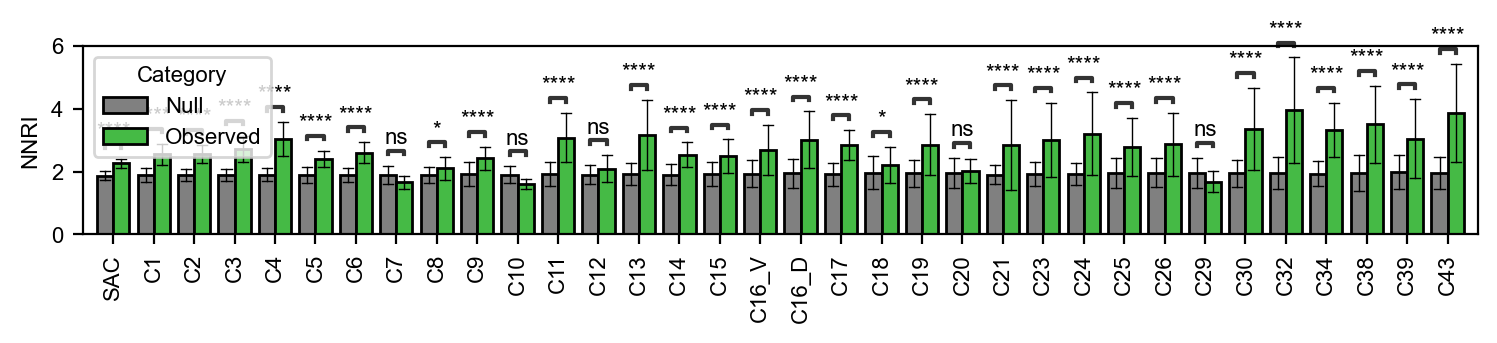

In [58]:
quant_mosaic(load_trial('filt1_exclude_boundary',filt_pairs=filt_df['pair'].values,ri_key='NNRI'),suborder,type_col='Type',score_col='NNRI',color='limegreen',figsize=(9,1.25),test=None,ylim=(0,6),p_vals=df['Adjusted p-value'].values,output_f=os.path.join(REVIEWER_DIR,"mosaic","NNRI_barplot.pdf"))

In [27]:
pairs = ([('C1','Observed'),('C1-C2','Observed')],[('C2','Observed'),('C1-C2','Observed')],[('C3','Observed'),('C3-C4','Observed')],[('C4','Observed'),('C3-C4','Observed')],[('C16_V','Observed'),('C16','Observed')],[('C16_D','Observed'),('C16','Observed')])

In [28]:
df_t = pd.read_csv(os.path.join(MOSAIC_DATA_DIR,"NNRIS_recalc_filt1_mixtures.csv"),index_col=0)


162036
158079
([('C1', 'Observed'), ('C1-C2', 'Observed')], [('C2', 'Observed'), ('C1-C2', 'Observed')], [('C3', 'Observed'), ('C3-C4', 'Observed')], [('C4', 'Observed'), ('C3-C4', 'Observed')], [('C16_V', 'Observed'), ('C16', 'Observed')], [('C16_D', 'Observed'), ('C16', 'Observed')])
([('C1', 'Observed'), ('C1-C2', 'Observed')], [('C2', 'Observed'), ('C1-C2', 'Observed')], [('C3', 'Observed'), ('C3-C4', 'Observed')], [('C4', 'Observed'), ('C3-C4', 'Observed')], [('C16_V', 'Observed'), ('C16', 'Observed')], [('C16_D', 'Observed'), ('C16', 'Observed')])
6 6
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

C16_D_Observed vs. C16_Observed: Custom statistical test, P_val:3.906e-02
C4_Observed vs. C3-C4_Observed: Custom statistical test, P_val:3.906e-03
C2_Observed vs. C1-C2_Observed: Custom statistical test, P_val:7.812e-03
C16_V_Observed vs. C16_O

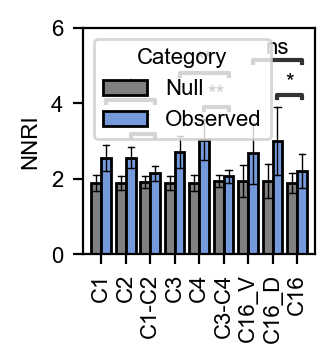

In [29]:
#trial_subset =['final_v3', 'filt3_exclude_boundary','filt1_exclude_boundary']
trial_subset =['filt1_mixtures']
mix_order = ['C1','C2','C1-C2','C3','C4','C3-C4','C16_V','C16_D','C16']
p_values = []
for pair in pairs:
    (t1,_),(t2,_) = pair
    x = df_t[(df_t['Type']==t1)&(df_t['Category']=='Observed')]['NNRI'].values
    y = df_t[(df_t['Type']==t2)&(df_t['Category']=='Observed')]['NNRI'].values
    p_values.append(scipy.stats.wilcoxon(x,y).pvalue)


quant_mosaic(load_trial('filt1_mixtures',ri_key='NNRI',filt_pairs=filt_df['pair'].values),mix_order,type_col='Type',score_col='NNRI',color='cornflowerblue',figsize=(1.5,1.5),pairs=pairs,test=None,ylim=(0,6),p_vals=p_values,output_f=os.path.join(REVIEWER_DIR,"mosaic","NNRI_mixture.pdf"))

In [30]:
p_values

[0.01171875, 0.0078125, 0.00390625, 0.00390625, 0.09765625, 0.0390625]

In [ ]:
#trial_subset =['final_v3', 'filt3_exclude_boundary','filt1_exclude_boundary']
trial_subset =['filt1_exclude_boundary']
df_jp = make_joint_p(trials=trial_subset,trial_map = TRIAL_MAP,exclude_bad_triples=False,do_diagnostic=False,order=suborder,figure_dir=os.path.join("..","intermediate_figures","mosaic","new_figures"),filt_pairs=filt_df['pair'].values,ri_key='NNRI')
df= adjust_p(df_jp,mult_correct=True)
#order = ['SAC', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'C15', 'C16_V', 'C16_D', 'C17', 'C18', 'C19', 'C20', 'C21', 'C23', 'C24', 'C25', 'C26', 'C29', 'C30', 'C32', 'C34', 'C38', 'C39', 'C43']
#order = ['SAC'] + [f'C{i}'.format(i) for i in range(1,16)] + ['C16_V','C16_D'] + [f'C{i}'.format(i) for i in range(17,46)]

df['Type'] = pd.Categorical(df['Type'],categories=suborder,ordered=True)
df= df.sort_values(by='Type')
quant_mosaic(load_trial('filt1_exclude_boundary',ri_key='NNRI',filt_pairs=filt_df['pair'].values),suborder,type_col='Type',score_col='NNRI',color='cornflowerblue',figsize=(9,1.25),test=None,ylim=(0,6),p_vals=df['Adjusted p-value'].values,output_f=os.path.join(REVIEWER_DIR,"mosaic","NNRI_barplot.pdf"))

In [9]:
#FOR NIKHIL: For visualization; check it out but not super important
from matplotlib.ticker import FormatStrFormatter
def plot_density(df_v,ctype,ax=None,roi=None,title=None,xlabel=None,ylabel=None,xlim=(0,100),run_type='nn',palette=None):
    if run_type == "nn":
        v = 'distances'
    elif run_type == "voronoi":
        v = 'areas'
    else:
        raise AssertionError("Not valid run_type")
    assert v in df_v.columns
    
    tmp = df_v[(df_v['Type']==ctype) & (df_v['Category']=='Null')]
    tmp2 = df_v[(df_v['Type']==ctype) & (df_v['Category']=='Observed')]
    if roi is not None:
        assert roi in tmp['roi'].unique() and roi in tmp2['roi'].unique()
        tmp = tmp[tmp['roi']==roi]
        tmp2 = tmp2[tmp2['roi']==roi]
    
    if ax is None:
        fig,ax = plt.subplots()
    
    with plt.rc_context({'font.sans-serif':'Arial'}):
        sns.kdeplot(tmp[v].values,ax=ax,color=NULL_COLOR if palette is None else palette['Null'],label='Random {}'.format(ctype))
        sns.kdeplot(tmp2[v].values,ax=ax,color=OBSERVED_COLOR if palette is None or ctype not in palette else palette[ctype],label='Observed {}'.format(ctype))
    ax.set_xlim(xlim)
    if xlabel is None and run_type == 'nn':
        xlabel = r'Nearest Neighbor Distance ($\mu m$)'
    elif xlabel is None and run_type == 'voronoi':
        xlabel = r'Voronoi Cell Area ($\mu m^2$)'
    if ylabel is None:
        ylabel = 'Density'
    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)
    if title is None:
        title=roi
    ax.set_title(title)
    ax.set_xticks(np.linspace(xlim[0],xlim[1],5))

def plot_voronoi(adata,ctype,run,sample_poly,ax,class_key="class",key='final_assignment',shrink=0,x='realigned_center_x',y='realigned_center_y',color='red',random_color='black',randomized=False,s=20):

    xl,yl,xu,yu = np.round(list(sample_poly.bounds))
    if ctype !='SAC':
        filt = (adata.obs['class']== 'RGC') & adata.obs[x].between(xl,xu) & adata.obs[y].between(yl,yu) & (adata.obs['run']==run)
    else:
        filt = (adata.obs['class']== 'Amacrine') & adata.obs[x].between(xl,xu) & adata.obs[y].between(yl,yu) & (adata.obs['run']==run)
    adata_rgc = adata[filt]
    if randomized:
        random_key = 'randomized_assignment'
        adata_rgc.obs[random_key] = pd.Series(adata_rgc.obs[key].sample(frac=1).values,adata_rgc.obs[key].index)
        key= random_key
    
    else:
        key=key
    adata_ctype = adata_rgc[adata_rgc.obs[key]==ctype]
    vor = ss.Voronoi(adata_ctype.obs[[x,y]])

    #fig = ss.voronoi_plot_2d(vor,show_points=False,show_vertices=False)
    if randomized:
        color=random_color
    adata_rem = adata_rgc[adata_rgc.obs[key]!=ctype]
    sns.scatterplot(adata_rem.obs,x=x,y=y,color='grey',palette='Set1',ax=ax,s=2)
    sns.scatterplot(adata_ctype.obs,x=x,y=y,color=color,ax=ax,s=s)
    
    ax.set_aspect('equal', adjustable='box')
    if randomized:
        ax.set_title(f'Randomized sample: {ctype}')
    else:
        ax.set_title(f'Observed sample: {ctype}')

    ax.set_xlim(xl+shrink,xu-shrink)
    ax.set_ylim(yl+shrink,yu-shrink)
    ax.tick_params(which='both',left=False,bottom=False,labelbottom=False,labelleft=False)
    ax.set_xlabel('')
    ax.set_ylabel('')

    return filt,vor


In [15]:
df_distances = pd.read_csv(os.path.join(MOSAIC_DATA_DIR,"dist_filt1_exclude_boundary.csv"),index_col=0)

In [31]:
sub_ROI = {
    3:{
        0:[make_square(95,-1052,920),make_square(444,-643,400)], #second is just for zoom in 
        1:[make_square(-1350,-850,600)], 
    },
    5:{
        0:[make_square(350, 60 ,780)], 
        1:[make_square(-1500, -600 ,780),  
           make_square(-600, -1520 ,780), 
           make_square(300, -500 ,1300), 
           ]
    },
    7:{
        0:[make_square(-1521,-94,700)],
        1:[make_square(935,0,1000)],
    },
    16:{
        3:[make_square(-500, -1500 ,1000)]  # good, LARGE w/ holes
    },
}


/var/folders/b3/jkbfjl310vdb0w4vhhz87pdr0000gn/T/ipykernel_17897/3086206584.py:61: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(adata_rem.obs,x=x,y=y,color='grey',palette='Set1',ax=ax,s=2)
/var/folders/b3/jkbfjl310vdb0w4vhhz87pdr0000gn/T/ipykernel_17897/3086206584.py:49: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_rgc.obs[random_key] = pd.Series(adata_rgc.obs[key].sample(frac=1).values,adata_rgc.obs[key].index)
/var/folders/b3/jkbfjl310vdb0w4vhhz87pdr0000gn/T/ipykernel_17897/3086206584.py:61: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(adata_rem.obs,x=x,y=y,color='grey',palette='Set1',ax=ax,s=2)
/var/folders/b3/jkbfjl310vdb0w4vhhz87pdr0000gn/T/ipykernel_17897/3086206584.py:61: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(adata_rem.obs,x=x,y=y,color='grey',palette='Set1',ax=

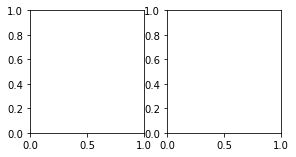

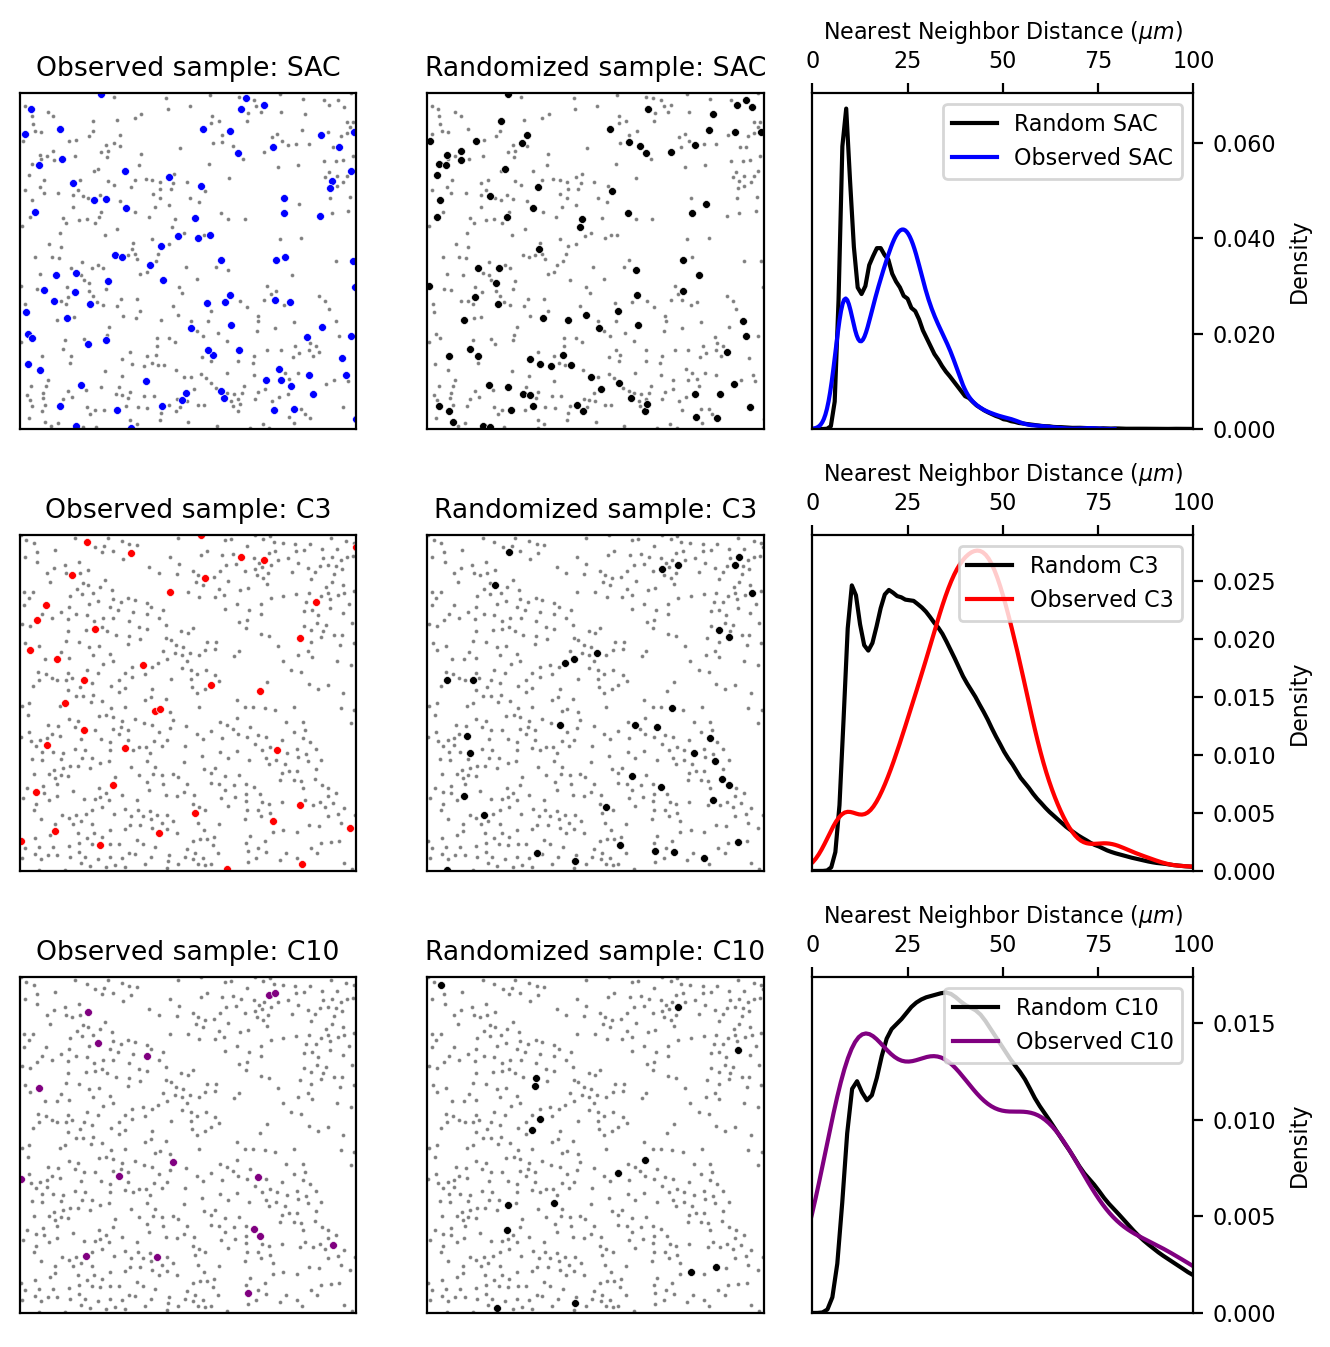

In [34]:
run = 3
w = h =  2.25
random_color='black'
figure_dir = os.path.join(constants.BASE_DIR,"figures","Figure_4")
fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(w*2,h))
ctypes=['SAC','C3','C10']
colors=['Blue','Red','Purple']
with plt.rc_context({'figure.dpi':200,'font.size':8,'font.sans-serif':'Arial'}):
    fig,ax= plt.subplots(ncols=3,nrows=len(ctypes),figsize=(w*3,h*len(ctypes)))
    for i,(ctype,color) in enumerate(zip(ctypes,colors)):
        ax_r = ax[i]
        
        _,vor = plot_voronoi(adata[adata.obs['Keep']],ctype=ctype,color=color,run=run,sample_poly=sg.Polygon(sub_ROI[run][0][1]),ax=ax_r[0],shrink=0,s=8)
        _,vor = plot_voronoi(adata[adata.obs['Keep']],ctype=ctype,run=run,random_color=random_color,sample_poly=sg.Polygon(sub_ROI[run][0][1]),shrink=0,ax=ax_r[1],randomized=True,s=8)


        palette = {ctype:color,'Null':random_color}
        plot_density(df_distances,ctype=ctype,ax=ax_r[2],palette=palette)
        ax_r[2].xaxis.tick_top()
        ax_r[2].xaxis.set_label_position('top')
        ax_r[2].yaxis.tick_right()
        ax_r[2].yaxis.set_label_position('right')
        ax_r[2].yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
        ax_r[2].legend(loc='upper right')

    
    fig.tight_layout()
    fig.savefig(os.path.join(figure_dir,"{}_joint_plot_dist{}.pdf".format(ctypes,suffix)))
    fig.show()